# EPAM DS course. Classification 1.1 Prudential Life Insurance Assessment

# Loading the needed libraries.

In [2]:
import pandas as pd
import numpy as np
from scipy import sparse

%matplotlib inline
import matplotlib.pylab as plt

import seaborn as sns

from tqdm import tqdm_notebook

import os
import itertools

from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Imputer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV,
StratifiedKFold, train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD

import category_encoders

# Helper functions and constants.

In [3]:
col_groups = [ "Medical_Keyword", "Product_Info", "Employment_Info", "InsuredInfo",
              "Insurance_History", "Family_Hist", "Medical_History"]


def plot_barh_func(df, bar=True):
    for i in list(df):
        plt.figure()
        plt.title(i)
        if bar == True:
            df[i].value_counts().plot.barh(figsize=(8, 6))
        else:
            df[i].plot.hist(bins=300, figsize=(8, 6))
        plt.show()
        
        
def get_group(df, column_name):
    return df[df.columns[df.columns.str.contains(column_name)]]


def complement_col_func(df, col_list):
    compl_list = list(set(list(df)) - (set(list(df)) & set(col_list)))
    return compl_list


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes) #, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid('off')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def fill_med(df, col_name):
    median = df[col_name].median()
    df[col_name].fillna(median, inplace=True)

# Loading the data.

In [4]:
pwd

'/home/student/Desktop/Datasets'

In [5]:
DATA_PATH = "class1_1/"

In [6]:
train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
train.shape

(59381, 128)

In [7]:
# test_df = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))
# test_df.shape

# EDA.

## Target variable and Id's, train/test split.


Let's look at the target variable. Classes are pretty imbalanced.


In [8]:
train.Response.isnull().sum()

0

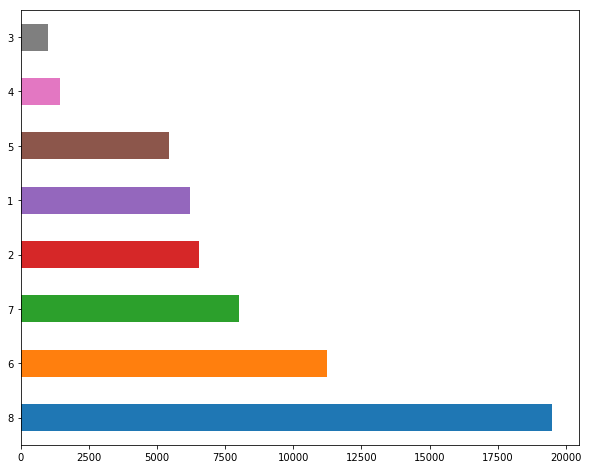

In [9]:
train.Response.value_counts().plot.barh(figsize=(10, 8))

Id's are unique.

In [10]:
print(train.Id.nunique(), train.shape)

59381 (59381, 128)


Separate id's and target variable.

In [11]:
y = train.pop("Response")
IDs = train.pop("Id")

Train/test split.

In [12]:
train_df, test_df, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=17, stratify=y)
train_df.shape

(41566, 126)

## First look at the data.

In [13]:
train_df.head().T

56199        42107     30424      38997     19945
Product_Info_1                1            1         1          1         1
Product_Info_2               D1           D3        A6         A1        D4
Product_Info_3               26           26        26         26        26
Product_Info_4         0.230769    0.0769231  0.487179  0.0769231  0.230769
Product_Info_5                2            2         2          2         2
Product_Info_6                1            3         3          3         3
Product_Info_7                1            1         1          1         1
Ins_Age                0.552239     0.656716  0.223881  0.0746269  0.313433
Ht                     0.727273          0.6  0.545455   0.618182  0.727273
Wt                     0.292887     0.361925  0.179916   0.138075  0.334728
BMI                    0.453578     0.747711  0.429384   0.270553  0.523369
Employment_Info_1         0.075            0     0.088      0.035      0.08
Employment_Info_2             9            1         9          9         9
Employment_Info_3             1            3         1          1         1
Employment_Info_4         0.012     0.014232         0          0       NaN
Employment_Info_5             2            2         2          2         2
Employment_Info_6           0.3          NaN     0.003      0.035      0.15
InsuredInfo_1                 1            1         1          2         1
InsuredInfo_2                 2            2         2          2         2
InsuredInfo_3                 8            3         6          3         8
InsuredInfo_4                 3            3         3          2         3
InsuredInfo_5                 1            1         1          1         1
InsuredInfo_6                 1            2         2          2         1
InsuredInfo_7                 1            1         1          1         1
Insurance_History_1           1            2         1          2         2
Insurance_History_2           1            1         1          1         1
Insurance_History_3           3            3         3          1         1
Insurance_History_4           1            1         1          3         3
Insurance_History_5  0.00166667  0.000113333  3.75e-05        NaN       NaN
Insurance_History_7           1            1         1          3         3
...                         ...          ...       ...        ...       ...
Medical_Keyword_19            0            0         0          0         0
Medical_Keyword_20            0            0         0          0         0
Medical_Keyword_21            0            0         0          0         0
Medical_Keyword_22            0            0         0          0         0
Medical_Keyword_23            0            0         0          0         0
Medical_Keyword_24            0            0         0          0         0
Medical_Keyword_25            0            1         0          0         0
Medical_Keyword_26            0            0         0          0         0
Medical_Keyword_27            0            0         0          0         0
Medical_Keyword_28            0            0         0          0         0
Medical_Keyword_29            0            0         0          0         0
Medical_Keyword_30            0            0         0          0         0
Medical_Keyword_31            0            0         0          0         0
Medical_Keyword_32            0            0         0          0         0
Medical_Keyword_33            0            0         0          0         0
Medical_Keyword_34            0            0         0          0         0
Medical_Keyword_35            0            0         0          0         0
Medical_Keyword_36            0            0         0          0         0
Medical_Keyword_37            0            0         0          0         0
Medical_Keyword_38            0            0         0          0         0
Medical_Keyword_39            0            0         1          0         

In [14]:
ProfileReport(train_df)

## Columns with NaNs.

In [ ]:
index_col_nan = train_df.isnull().sum().sort_values(ascending=False) > 0

In [ ]:
list_col_nan = list(train_df.isnull().sum().sort_values(ascending=False).loc[index_col_nan].keys())
list_col_nan

In [20]:
train_df[list_col_nan].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41566 entries, 56199 to 38060
Data columns (total 13 columns):
Medical_History_10     389 non-null float64
Medical_History_32     780 non-null float64
Medical_History_24     2650 non-null float64
Medical_History_15     10374 non-null float64
Family_Hist_5          12306 non-null float64
Family_Hist_3          17540 non-null float64
Family_Hist_2          21485 non-null float64
Insurance_History_5    23910 non-null float64
Family_Hist_4          28109 non-null float64
Employment_Info_6      33861 non-null float64
Medical_History_1      35316 non-null float64
Employment_Info_4      36876 non-null float64
Employment_Info_1      41551 non-null float64
dtypes: float64(13)
memory usage: 4.4 MB


In [21]:
train_df[list_col_nan].describe().T

count        mean         std       min        25%  \
Medical_History_10     389.0  141.359897  108.887386  0.000000   6.000000   
Medical_History_32     780.0   12.835897   40.592578  0.000000   0.000000   
Medical_History_24    2650.0   50.775094   78.927293  0.000000   1.000000   
Medical_History_15   10374.0  124.471853   98.605237  0.000000  18.000000   
Family_Hist_5        12306.0    0.485285    0.128162  0.000000   0.401786   
Family_Hist_3        17540.0    0.497782    0.141118  0.000000   0.401961   
Family_Hist_2        21485.0    0.475021    0.155269  0.028986   0.362319   
Insurance_History_5  23910.0    0.001737    0.007581  0.000000   0.000400   
Family_Hist_4        28109.0    0.445222    0.163748  0.000000   0.323944   
Employment_Info_6    33861.0    0.363401    0.350391  0.000000   0.060000   
Medical_History_1    35316.0    7.967097   12.874622  0.000000   2.000000   
Employment_Info_4    36876.0    0.006427    0.034496  0.000000   0.000000   
Employment_Info_1    41551.0    0.077702    0.082814  0.000000   0.035000   

                            50%         75%         max  
Medical_History_10   235.000000  240.000000  240.000000  
Medical_History_32     0.000000    2.000000  240.000000  
Medical_History_24     8.000000   62.000000  240.000000  
Medical_History_15   118.000000  240.000000  240.000000  
Family_Hist_5          0.508929    0.580357    1.000000  
Family_Hist_3          0.519608    0.607843    1.000000  
Family_Hist_2          0.463768    0.579710    1.000000  
Insurance_History_5    0.001000    0.002000    1.000000  
Family_Hist_4          0.422535    0.563380    0.943662  
Employment_Info_6      0.250000    0.550000    1.000000  
Medical_History_1      4.000000   10.000000  240.000000  
Employment_Info_4      0.000000    0.000000    1.000000  
Employment_Info_1      0.060000    0.100000    1.000000

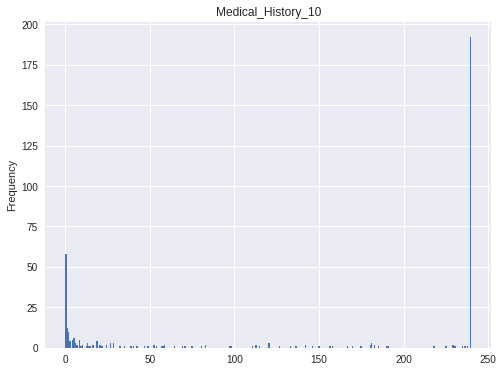

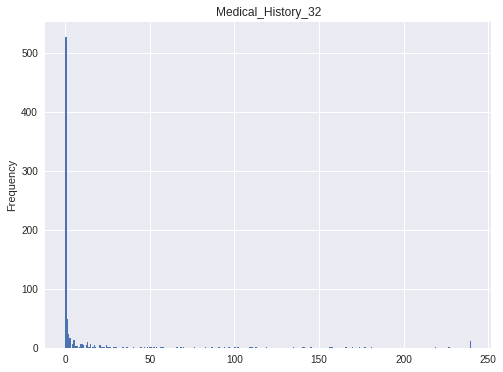

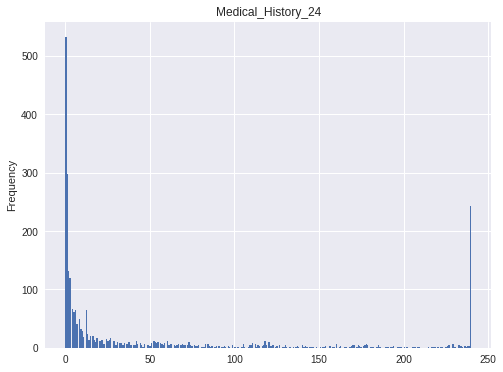

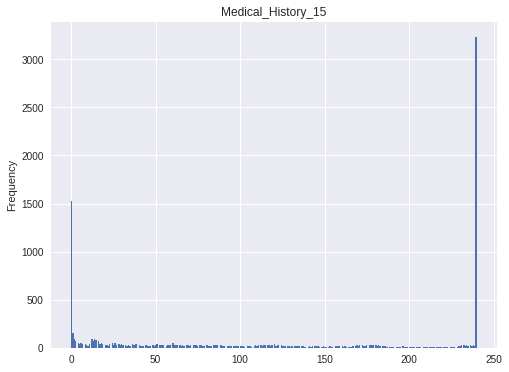

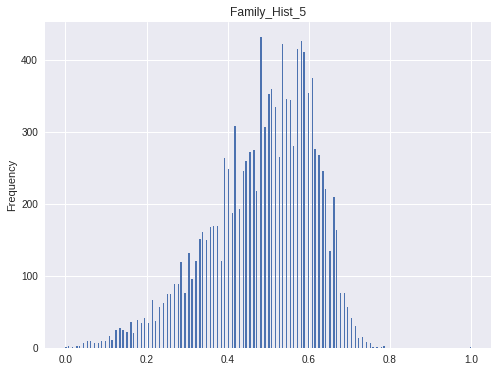

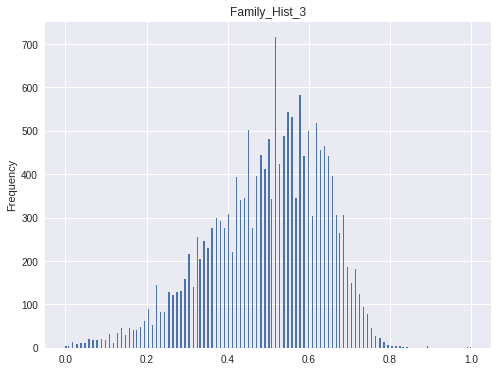

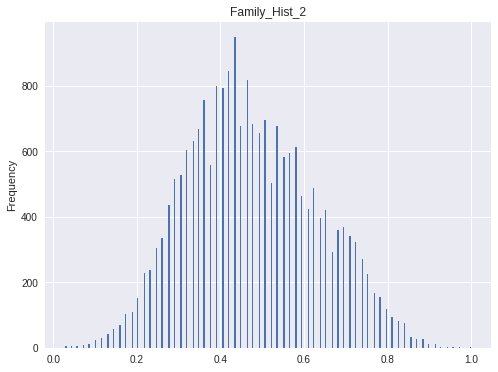

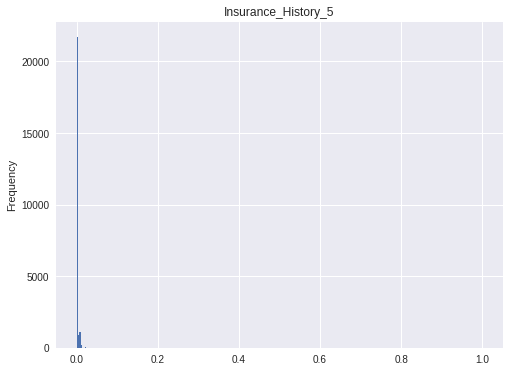

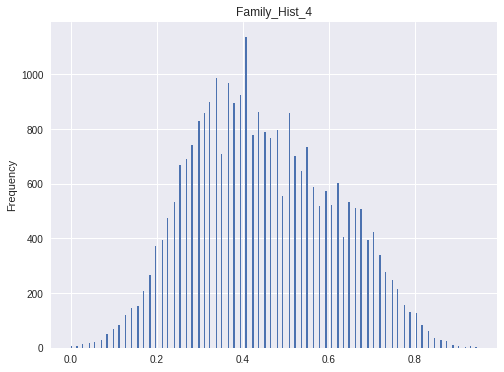

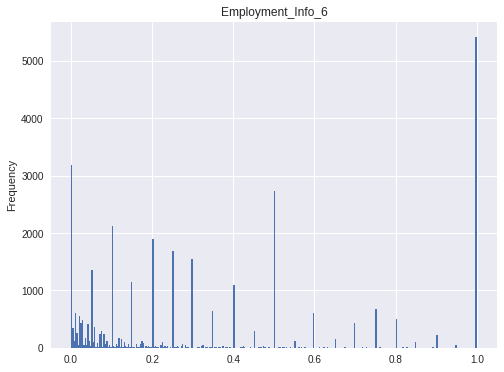

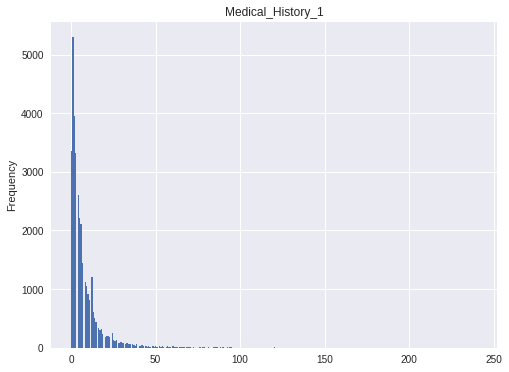

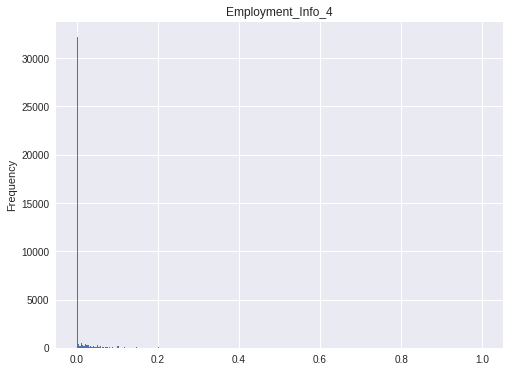

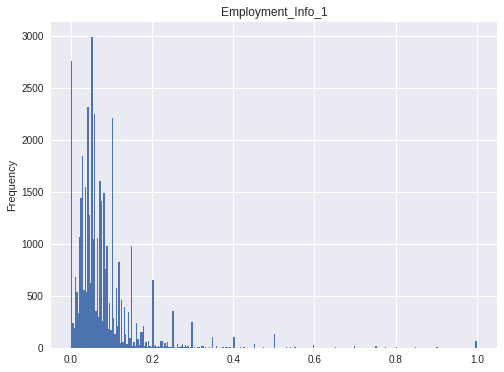

In [22]:
plot_barh_func((train_df[list_col_nan]), bar=False)

We will proceed with NaN's later.

## Medical_Keyword.

In [23]:
col_groups[0]

'Medical_Keyword'

In [24]:
Medical_Keyword_df = get_group( train_df, "Medical_Keyword")

In [25]:
Medical_Keyword_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41566 entries, 56199 to 38060
Data columns (total 48 columns):
Medical_Keyword_1     41566 non-null int64
Medical_Keyword_2     41566 non-null int64
Medical_Keyword_3     41566 non-null int64
Medical_Keyword_4     41566 non-null int64
Medical_Keyword_5     41566 non-null int64
Medical_Keyword_6     41566 non-null int64
Medical_Keyword_7     41566 non-null int64
Medical_Keyword_8     41566 non-null int64
Medical_Keyword_9     41566 non-null int64
Medical_Keyword_10    41566 non-null int64
Medical_Keyword_11    41566 non-null int64
Medical_Keyword_12    41566 non-null int64
Medical_Keyword_13    41566 non-null int64
Medical_Keyword_14    41566 non-null int64
Medical_Keyword_15    41566 non-null int64
Medical_Keyword_16    41566 non-null int64
Medical_Keyword_17    41566 non-null int64
Medical_Keyword_18    41566 non-null int64
Medical_Keyword_19    41566 non-null int64
Medical_Keyword_20    41566 non-null int64
Medical_Keyword_21    41566

In [26]:
Medical_Keyword_df.describe().T

count      mean       std  min  25%  50%  75%  max
Medical_Keyword_1   41566.0  0.042390  0.201481  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_2   41566.0  0.008781  0.093297  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_3   41566.0  0.049151  0.216185  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_4   41566.0  0.014772  0.120639  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_5   41566.0  0.008637  0.092534  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_6   41566.0  0.012631  0.111675  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_7   41566.0  0.013521  0.115491  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_8   41566.0  0.010730  0.103029  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_9   41566.0  0.006640  0.081216  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_10  41566.0  0.036400  0.187285  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_11  41566.0  0.058533  0.234752  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_12  41566.0  0.010369  0.101300  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_13  41566.0  0.005870  0.076393  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_14  41566.0  0.007843  0.088214  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_15  41566.0  0.191358  0.393375  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_16  41566.0  0.012823  0.112512  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_17  41566.0  0.009070  0.094804  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_18  41566.0  0.007554  0.086587  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_19  41566.0  0.009022  0.094555  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_20  41566.0  0.008565  0.092150  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_21  41566.0  0.014339  0.118884  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_22  41566.0  0.037988  0.191169  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_23  41566.0  0.096738  0.295604  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_24  41566.0  0.019271  0.137476  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_25  41566.0  0.088967  0.284699  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_26  41566.0  0.013208  0.114166  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_27  41566.0  0.011764  0.107825  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_28  41566.0  0.015614  0.123977  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_29  41566.0  0.011788  0.107934  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_30  41566.0  0.024636  0.155014  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_31  41566.0  0.010513  0.101996  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_32  41566.0  0.021388  0.144675  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_33  41566.0  0.022807  0.149290  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_34  41566.0  0.020907  0.143073  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_35  41566.0  0.006784  0.082089  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_36  41566.0  0.010658  0.102686  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_37  41566.0  0.065703  0.247765  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_38  41566.0  0.007217  0.084649  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_39  41566.0  0.014050  0.117698  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_40  41566.0  0.058197  0.234118  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_41  41566.0  0.010513  0.101996  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_42  41566.0  0.045927  0.209329  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_43  41566.0  0.010826  0.103485  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_44  41566.0  0.007530  0.086450  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_45  41566.0  0.013882  0.117001  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_46  41566.0  0.008372  0.091117  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_47  41566.0  0.019704  0.138981  0.0  0.0  0.0  0.0  1.0
Medical_Keyword_48  41566.0  0.054540  0.227082  0.0  0.0  0.0  0.0  1.0

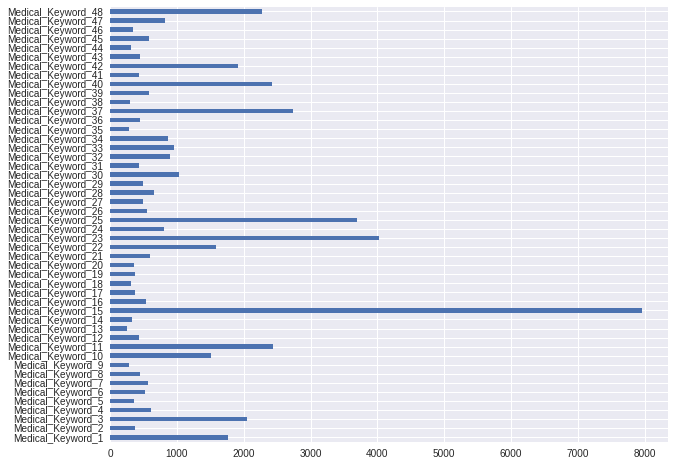

In [27]:
Medical_Keyword_df.sum().plot.barh(figsize=(10, 8))

## Product Info.

In [28]:
col_groups[1]

'Product_Info'

In [29]:
Product_Info_df = get_group( train_df, "Product_Info")

In [30]:
Product_Info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41566 entries, 56199 to 38060
Data columns (total 7 columns):
Product_Info_1    41566 non-null int64
Product_Info_2    41566 non-null object
Product_Info_3    41566 non-null int64
Product_Info_4    41566 non-null float64
Product_Info_5    41566 non-null int64
Product_Info_6    41566 non-null int64
Product_Info_7    41566 non-null int64
dtypes: float64(1), int64(5), object(1)
memory usage: 2.5+ MB


In [31]:
Product_Info_df.describe().T

count       mean       std  min        25%        50%  \
Product_Info_1  41566.0   1.025646  0.158079  1.0   1.000000   1.000000   
Product_Info_3  41566.0  24.417144  5.066122  1.0  26.000000  26.000000   
Product_Info_4  41566.0   0.329297  0.281972  0.0   0.076923   0.230769   
Product_Info_5  41566.0   2.006808  0.082233  2.0   2.000000   2.000000   
Product_Info_6  41566.0   2.675937  0.736968  1.0   3.000000   3.000000   
Product_Info_7  41566.0   1.043329  0.291132  1.0   1.000000   1.000000   

                      75%   max  
Product_Info_1   1.000000   2.0  
Product_Info_3  26.000000  37.0  
Product_Info_4   0.487179   1.0  
Product_Info_5   2.000000   3.0  
Product_Info_6   3.000000   3.0  
Product_Info_7   1.000000   3.0

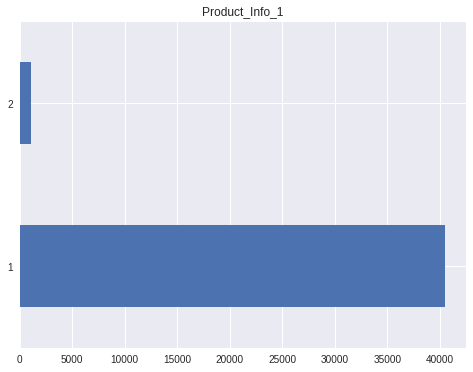

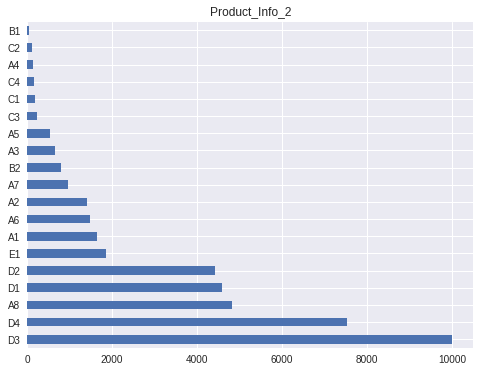

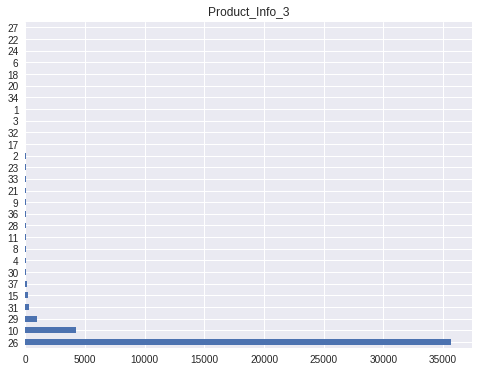

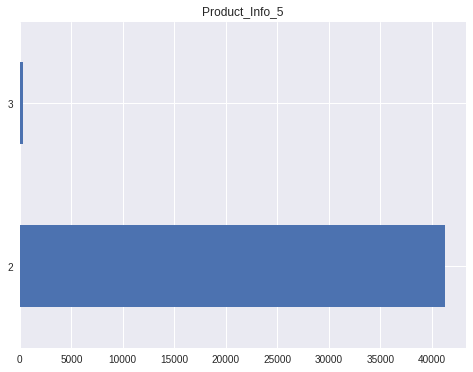

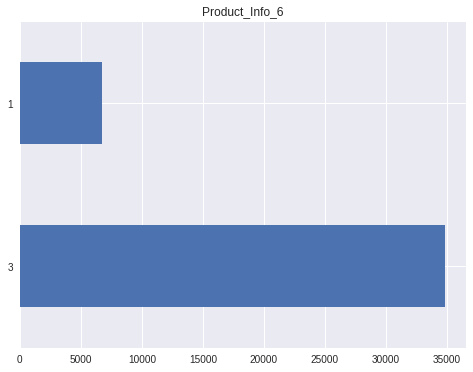

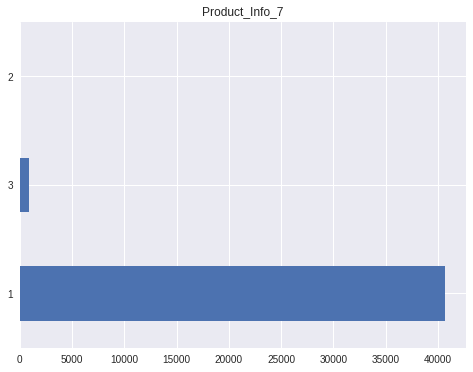

In [32]:
col_list_temp = list(Product_Info_df)
col_list_temp.remove("Product_Info_4")

plot_barh_func(Product_Info_df[col_list_temp])

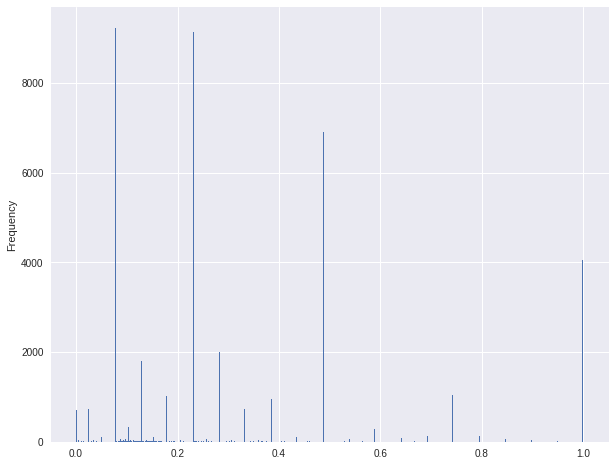

In [33]:
Product_Info_df.Product_Info_4.plot.hist( bins=500, figsize=(10, 8))

Conclusion: all columns in Product_Info_df despite of "Product_Info_4" are categorical.

In [34]:
train_df[col_list_temp] = train_df[col_list_temp].astype('object')

## Employment_Info.

In [35]:
col_groups[2]

'Employment_Info'

In [36]:
Employment_Info_df = get_group( train_df, "Employment_Info")

In [37]:
Employment_Info_df.head().T

56199     42107  30424  38997  19945
Employment_Info_1  0.075  0.000000  0.088  0.035   0.08
Employment_Info_2  9.000  1.000000  9.000  9.000   9.00
Employment_Info_3  1.000  3.000000  1.000  1.000   1.00
Employment_Info_4  0.012  0.014232  0.000  0.000    NaN
Employment_Info_5  2.000  2.000000  2.000  2.000   2.00
Employment_Info_6  0.300       NaN  0.003  0.035   0.15

In [38]:
Employment_Info_df.describe().T

count      mean       std  min    25%   50%   75%   max
Employment_Info_1  41551.0  0.077702  0.082814  0.0  0.035  0.06  0.10   1.0
Employment_Info_2  41566.0  8.630756  4.240703  1.0  9.000  9.00  9.00  38.0
Employment_Info_3  41566.0  1.303854  0.717909  1.0  1.000  1.00  1.00   3.0
Employment_Info_4  36876.0  0.006427  0.034496  0.0  0.000  0.00  0.00   1.0
Employment_Info_5  41566.0  2.142544  0.349612  2.0  2.000  2.00  2.00   3.0
Employment_Info_6  33861.0  0.363401  0.350391  0.0  0.060  0.25  0.55   1.0

In [39]:
Employment_Info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41566 entries, 56199 to 38060
Data columns (total 6 columns):
Employment_Info_1    41551 non-null float64
Employment_Info_2    41566 non-null int64
Employment_Info_3    41566 non-null int64
Employment_Info_4    36876 non-null float64
Employment_Info_5    41566 non-null int64
Employment_Info_6    33861 non-null float64
dtypes: float64(3), int64(3)
memory usage: 2.2 MB


In [40]:
list_Employment_Info_col_wo_nan = complement_col_func( Employment_Info_df, list_col_nan)
list_Employment_Info_col_wo_nan 

['Employment_Info_5', 'Employment_Info_3', 'Employment_Info_2']

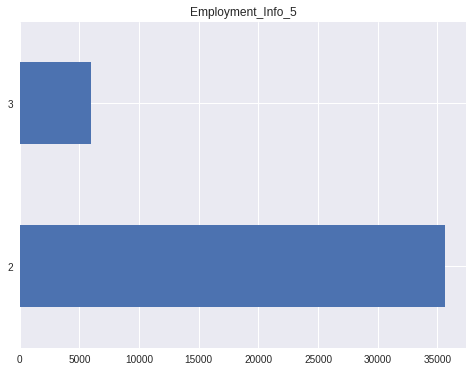

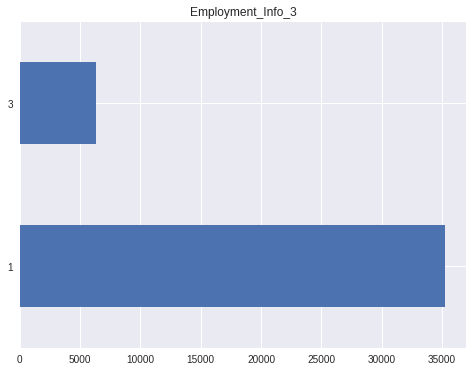

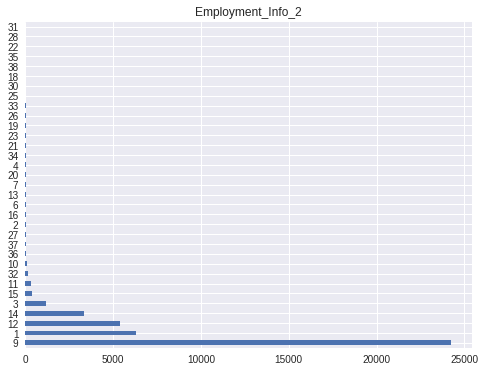

In [41]:
plot_barh_func(Employment_Info_df[list_Employment_Info_col_wo_nan], bar=True)

In [42]:
train_df[list_Employment_Info_col_wo_nan] = train_df[list_Employment_Info_col_wo_nan].astype('object')

## InsuredInfo.

In [43]:
col_groups[3]

'InsuredInfo'

In [44]:
InsuredInfo_df = get_group( train_df, "InsuredInfo")

In [45]:
InsuredInfo_df.head().T

56199  42107  30424  38997  19945
InsuredInfo_1      1      1      1      2      1
InsuredInfo_2      2      2      2      2      2
InsuredInfo_3      8      3      6      3      8
InsuredInfo_4      3      3      3      2      3
InsuredInfo_5      1      1      1      1      1
InsuredInfo_6      1      2      2      2      1
InsuredInfo_7      1      1      1      1      1

In [46]:
InsuredInfo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41566 entries, 56199 to 38060
Data columns (total 7 columns):
InsuredInfo_1    41566 non-null int64
InsuredInfo_2    41566 non-null int64
InsuredInfo_3    41566 non-null int64
InsuredInfo_4    41566 non-null int64
InsuredInfo_5    41566 non-null int64
InsuredInfo_6    41566 non-null int64
InsuredInfo_7    41566 non-null int64
dtypes: int64(7)
memory usage: 2.5 MB


In [47]:
InsuredInfo_df.describe().T

count      mean       std  min  25%  50%  75%   max
InsuredInfo_1  41566.0  1.209594  0.418392  1.0  1.0  1.0  1.0   3.0
InsuredInfo_2  41566.0  2.007771  0.087810  2.0  2.0  2.0  2.0   3.0
InsuredInfo_3  41566.0  5.851754  2.675778  1.0  3.0  6.0  8.0  11.0
InsuredInfo_4  41566.0  2.884088  0.320123  2.0  3.0  3.0  3.0   3.0
InsuredInfo_5  41566.0  1.026993  0.230779  1.0  1.0  1.0  1.0   3.0
InsuredInfo_6  41566.0  1.408651  0.491591  1.0  1.0  1.0  2.0   2.0
InsuredInfo_7  41566.0  1.039119  0.276963  1.0  1.0  1.0  1.0   3.0

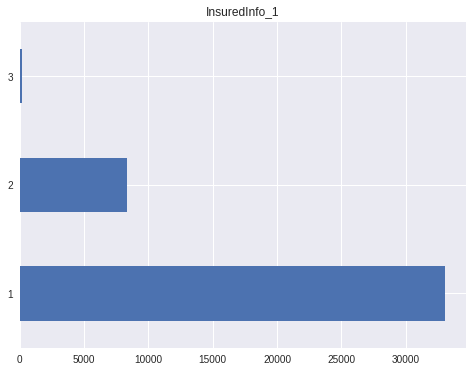

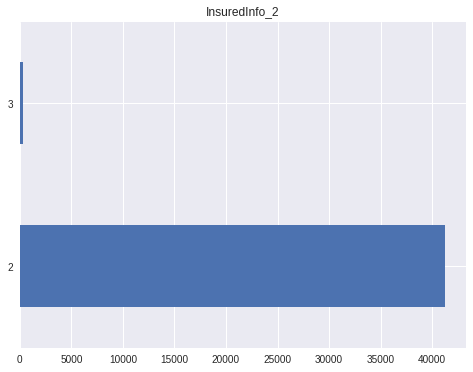

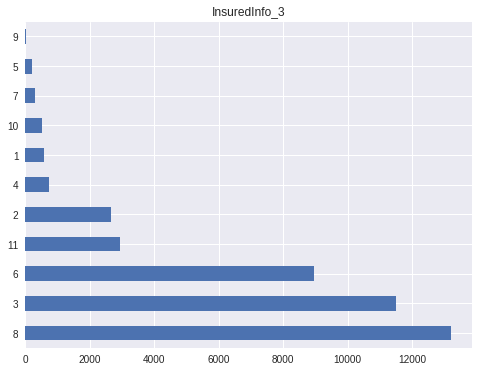

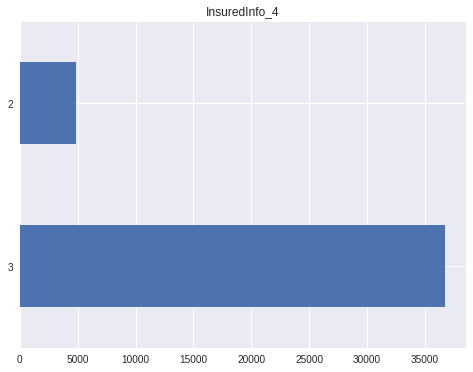

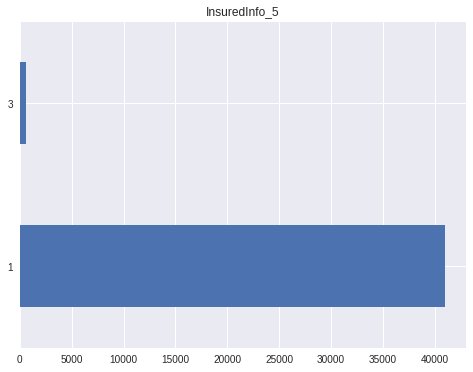

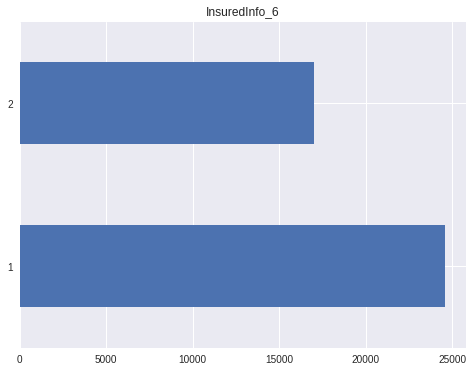

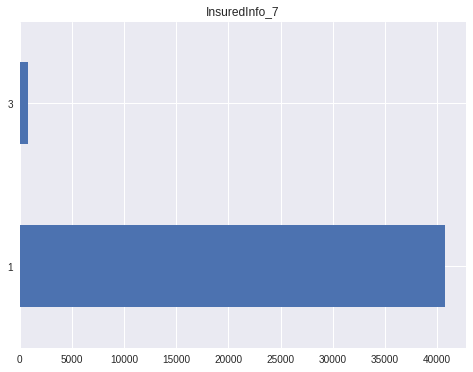

In [48]:
plot_barh_func( InsuredInfo_df, bar=True)

In [49]:
train_df[ list( InsuredInfo_df)] = train_df[ list( InsuredInfo_df)].astype('object')

## Insurance_History.

In [50]:
col_groups[4]

'Insurance_History'

In [51]:
Insurance_History_df = get_group( train_df, "Insurance_History")

In [52]:
Insurance_History_df.head().T

56199     42107     30424  38997  19945
Insurance_History_1  1.000000  2.000000  1.000000    2.0    2.0
Insurance_History_2  1.000000  1.000000  1.000000    1.0    1.0
Insurance_History_3  3.000000  3.000000  3.000000    1.0    1.0
Insurance_History_4  1.000000  1.000000  1.000000    3.0    3.0
Insurance_History_5  0.001667  0.000113  0.000037    NaN    NaN
Insurance_History_7  1.000000  1.000000  1.000000    3.0    3.0
Insurance_History_8  1.000000  3.000000  1.000000    2.0    2.0
Insurance_History_9  2.000000  2.000000  2.000000    3.0    3.0

In [53]:
Insurance_History_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41566 entries, 56199 to 38060
Data columns (total 8 columns):
Insurance_History_1    41566 non-null int64
Insurance_History_2    41566 non-null int64
Insurance_History_3    41566 non-null int64
Insurance_History_4    41566 non-null int64
Insurance_History_5    23910 non-null float64
Insurance_History_7    41566 non-null int64
Insurance_History_8    41566 non-null int64
Insurance_History_9    41566 non-null int64
dtypes: float64(1), int64(7)
memory usage: 2.9 MB


In [54]:
Insurance_History_df.describe().T

count      mean       std  min     25%    50%    75%  \
Insurance_History_1  41566.0  1.726074  0.445977  1.0  1.0000  2.000  2.000   
Insurance_History_2  41566.0  1.056440  0.331207  1.0  1.0000  1.000  1.000   
Insurance_History_3  41566.0  2.152529  0.988311  1.0  1.0000  3.000  3.000   
Insurance_History_4  41566.0  1.954723  0.944646  1.0  1.0000  2.000  3.000   
Insurance_History_5  23910.0  0.001737  0.007581  0.0  0.0004  0.001  0.002   
Insurance_History_7  41566.0  1.897705  0.970081  1.0  1.0000  1.000  3.000   
Insurance_History_8  41566.0  2.048934  0.756995  1.0  1.0000  2.000  3.000   
Insurance_History_9  41566.0  2.416494  0.509164  1.0  2.0000  2.000  3.000   

                     max  
Insurance_History_1  2.0  
Insurance_History_2  3.0  
Insurance_History_3  3.0  
Insurance_History_4  3.0  
Insurance_History_5  1.0  
Insurance_History_7  3.0  
Insurance_History_8  3.0  
Insurance_History_9  3.0

['Insurance_History_8', 'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_2', 'Insurance_History_1', 'Insurance_History_7', 'Insurance_History_9']


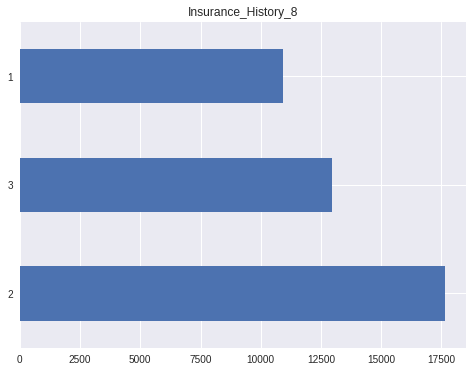

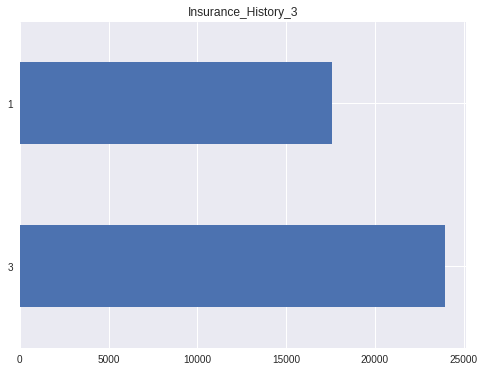

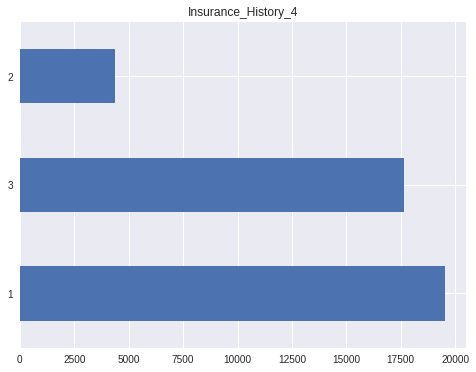

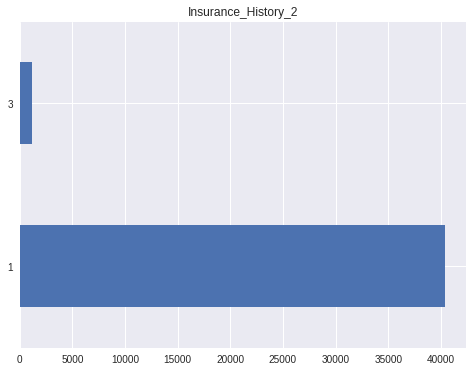

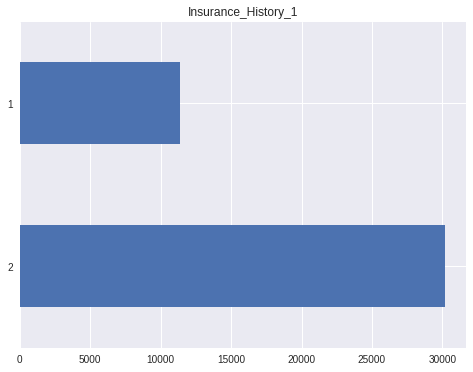

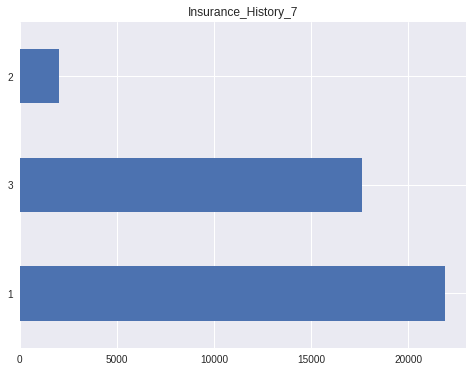

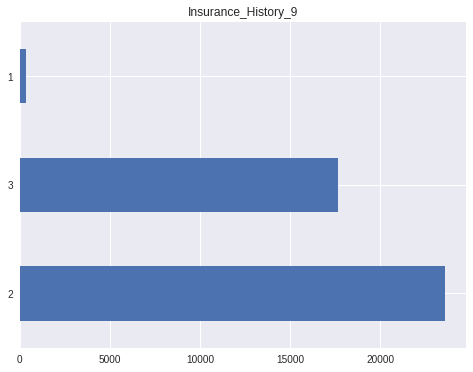

In [55]:
list_Insurance_History_col_wo_nan = complement_col_func( Insurance_History_df, list_col_nan)
print(list_Insurance_History_col_wo_nan)
plot_barh_func( Insurance_History_df[list_Insurance_History_col_wo_nan], bar=True)

In [56]:
train_df[list_Insurance_History_col_wo_nan] = train_df[list_Insurance_History_col_wo_nan].astype('object')

## Family_Hist.

In [57]:
col_groups[5]

'Family_Hist'

In [58]:
Family_Hist_df = get_group( train_df, "Family_Hist")

In [59]:
Family_Hist_df.head().T

56199     42107     30424     38997     19945
Family_Hist_1  2.000000  2.000000  3.000000  2.000000  2.000000
Family_Hist_2       NaN       NaN  0.318841  0.304348  0.463768
Family_Hist_3  0.460784       NaN       NaN       NaN       NaN
Family_Hist_4       NaN       NaN  0.295775  0.225352  0.408451
Family_Hist_5  0.428571  0.446429       NaN       NaN       NaN

In [60]:
Family_Hist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41566 entries, 56199 to 38060
Data columns (total 5 columns):
Family_Hist_1    41566 non-null int64
Family_Hist_2    21485 non-null float64
Family_Hist_3    17540 non-null float64
Family_Hist_4    28109 non-null float64
Family_Hist_5    12306 non-null float64
dtypes: float64(4), int64(1)
memory usage: 1.9 MB


In [61]:
Family_Hist_df.describe().T

count      mean       std       min       25%       50%  \
Family_Hist_1  41566.0  2.685560  0.483886  1.000000  2.000000  3.000000   
Family_Hist_2  21485.0  0.475021  0.155269  0.028986  0.362319  0.463768   
Family_Hist_3  17540.0  0.497782  0.141118  0.000000  0.401961  0.519608   
Family_Hist_4  28109.0  0.445222  0.163748  0.000000  0.323944  0.422535   
Family_Hist_5  12306.0  0.485285  0.128162  0.000000  0.401786  0.508929   

                    75%       max  
Family_Hist_1  3.000000  3.000000  
Family_Hist_2  0.579710  1.000000  
Family_Hist_3  0.607843  1.000000  
Family_Hist_4  0.563380  0.943662  
Family_Hist_5  0.580357  1.000000

['Family_Hist_1']


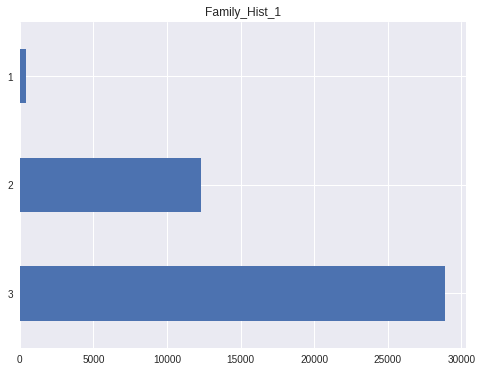

In [62]:
list_Family_Hist_col_wo_nan = complement_col_func( Family_Hist_df, list_col_nan)
print(list_Family_Hist_col_wo_nan)
plot_barh_func( Family_Hist_df[list_Family_Hist_col_wo_nan], bar=True)

In [63]:
train_df[list_Family_Hist_col_wo_nan] = train_df[list_Family_Hist_col_wo_nan].astype('object')

## Medical_History.

In [64]:
col_groups[6]

'Medical_History'

In [65]:
Medical_History_df = get_group( train_df, "Medical_History")

In [66]:
Medical_History_df.head().T

56199  42107  30424  38997  19945
Medical_History_1     4.0    1.0   47.0    1.0    0.0
Medical_History_2   565.0  132.0  160.0  335.0  161.0
Medical_History_3     2.0    2.0    2.0    2.0    2.0
Medical_History_4     2.0    2.0    2.0    2.0    1.0
Medical_History_5     1.0    1.0    1.0    1.0    1.0
Medical_History_6     3.0    3.0    3.0    3.0    3.0
Medical_History_7     2.0    2.0    2.0    2.0    2.0
Medical_History_8     2.0    2.0    2.0    2.0    2.0
Medical_History_9     2.0    2.0    2.0    2.0    2.0
Medical_History_10    NaN    NaN    NaN    NaN    NaN
Medical_History_11    3.0    3.0    3.0    3.0    3.0
Medical_History_12    2.0    2.0    2.0    2.0    2.0
Medical_History_13    3.0    3.0    3.0    3.0    3.0
Medical_History_14    3.0    3.0    3.0    3.0    3.0
Medical_History_15    NaN    NaN    NaN    NaN   39.0
Medical_History_16    1.0    3.0    1.0    1.0    1.0
Medical_History_17    3.0    3.0    3.0    3.0    3.0
Medical_History_18    1.0    1.0    1.0    1.0    1.0
Medical_History_19    1.0    1.0    1.0    1.0    1.0
Medical_History_20    2.0    2.0    2.0    2.0    2.0
Medical_History_21    1.0    1.0    1.0    1.0    1.0
Medical_History_22    2.0    2.0    2.0    2.0    2.0
Medical_History_23    3.0    1.0    3.0    3.0    1.0
Medical_History_24    NaN    NaN    NaN    NaN    NaN
Medical_History_25    1.0    1.0    1.0    1.0    1.0
Medical_History_26    3.0    3.0    3.0    3.0    3.0
Medical_History_27    3.0    3.0    3.0    3.0    3.0
Medical_History_28    1.0    2.0    1.0    1.0    1.0
Medical_History_29    3.0    1.0    1.0    3.0    3.0
Medical_History_30    2.0    2.0    2.0    2.0    2.0
Medical_History_31    3.0    3.0    3.0    3.0    3.0
Medical_History_32    NaN    NaN    NaN    NaN    NaN
Medical_History_33    3.0    3.0    3.0    3.0    3.0
Medical_History_34    3.0    1.0    3.0    3.0    3.0
Medical_History_35    1.0    1.0    1.0    1.0    1.0
Medical_History_36    2.0    2.0    2.0    2.0    2.0
Medical_History_37    2.0    1.0    2.0    2.0    2.0
Medical_History_38    1.0    1.0    1.0    1.0    1.0
Medical_History_39    3.0    1.0    3.0    3.0    3.0
Medical_History_40    3.0    3.0    3.0    3.0    3.0
Medical_History_41    1.0    3.0    3.0    1.0    3.0

In [67]:
Medical_History_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41566 entries, 56199 to 38060
Data columns (total 41 columns):
Medical_History_1     35316 non-null float64
Medical_History_2     41566 non-null int64
Medical_History_3     41566 non-null int64
Medical_History_4     41566 non-null int64
Medical_History_5     41566 non-null int64
Medical_History_6     41566 non-null int64
Medical_History_7     41566 non-null int64
Medical_History_8     41566 non-null int64
Medical_History_9     41566 non-null int64
Medical_History_10    389 non-null float64
Medical_History_11    41566 non-null int64
Medical_History_12    41566 non-null int64
Medical_History_13    41566 non-null int64
Medical_History_14    41566 non-null int64
Medical_History_15    10374 non-null float64
Medical_History_16    41566 non-null int64
Medical_History_17    41566 non-null int64
Medical_History_18    41566 non-null int64
Medical_History_19    41566 non-null int64
Medical_History_20    41566 non-null int64
Medical_History_21    4

In [68]:
Medical_History_df.describe().T

count        mean         std  min    25%    50%    75%  \
Medical_History_1   35316.0    7.967097   12.874622  0.0    2.0    4.0   10.0   
Medical_History_2   41566.0  254.139922  178.495276  1.0  112.0  162.0  416.0   
Medical_History_3   41566.0    2.102728    0.303845  1.0    2.0    2.0    2.0   
Medical_History_4   41566.0    1.654429    0.475560  1.0    1.0    2.0    2.0   
Medical_History_5   41566.0    1.007338    0.085628  1.0    1.0    1.0    1.0   
Medical_History_6   41566.0    2.889886    0.456162  1.0    3.0    3.0    3.0   
Medical_History_7   41566.0    2.012775    0.173293  1.0    2.0    2.0    2.0   
Medical_History_8   41566.0    2.043377    0.291620  1.0    2.0    2.0    2.0   
Medical_History_9   41566.0    1.770967    0.420330  1.0    2.0    2.0    2.0   
Medical_History_10    389.0  141.359897  108.887386  0.0    6.0  235.0  240.0   
Medical_History_11  41566.0    2.993985    0.094920  1.0    3.0    3.0    3.0   
Medical_History_12  41566.0    2.056873    0.231707  1.0    2.0    2.0    2.0   
Medical_History_13  41566.0    2.765505    0.643418  1.0    3.0    3.0    3.0   
Medical_History_14  41566.0    2.968027    0.199151  1.0    3.0    3.0    3.0   
Medical_History_15  10374.0  124.471853   98.605237  0.0   18.0  118.0  240.0   
Medical_History_16  41566.0    1.328995    0.741445  1.0    1.0    1.0    1.0   
Medical_History_17  41566.0    2.978492    0.145238  1.0    3.0    3.0    3.0   
Medical_History_18  41566.0    1.054107    0.226762  1.0    1.0    1.0    1.0   
Medical_History_19  41566.0    1.034066    0.181799  1.0    1.0    1.0    1.0   
Medical_History_20  41566.0    1.985373    0.120257  1.0    2.0    2.0    2.0   
Medical_History_21  41566.0    1.110836    0.314086  1.0    1.0    1.0    1.0   
Medical_History_22  41566.0    1.982125    0.132499  1.0    2.0    2.0    2.0   
Medical_History_23  41566.0    2.527956    0.849268  1.0    3.0    3.0    3.0   
Medical_History_24   2650.0   50.775094   78.927293  0.0    1.0    8.0   62.0   
Medical_History_25  41566.0    1.193499    0.404910  1.0    1.0    1.0    1.0   
Medical_History_26  41566.0    2.810398    0.392175  1.0    3.0    3.0    3.0   
Medical_History_27  41566.0    2.979454    0.201310  1.0    3.0    3.0    3.0   
Medical_History_28  41566.0    1.067387    0.250790  1.0    1.0    1.0    1.0   
Medical_History_29  41566.0    2.542655    0.839937  1.0    3.0    3.0    3.0   
Medical_History_30  41566.0    2.041909    0.200624  1.0    2.0    2.0    2.0   
Medical_History_31  41566.0    2.985926    0.167112  1.0    3.0    3.0    3.0   
Medical_History_32    780.0   12.835897   40.592578  0.0    0.0    0.0    2.0   
Medical_History_33  41566.0    2.806525    0.591208  1.0    3.0    3.0    3.0   
Medical_History_34  41566.0    2.689386    0.724387  1.0    3.0    3.0    3.0   
Medical_History_35  41566.0    1.002045    0.063732  1.0    1.0    1.0    1.0   
Medical_History_36  41566.0    2.178391    0.410913  1.0    2.0    2.0    2.0   
Medical_History_37  41566.0    1.938026    0.241210  1.0    2.0    2.0    2.0   
Medical_History_38  41566.0    1.004836    0.069372  1.0    1.0    1.0    1.0   
Medical_History_39  41566.0    2.831617    0.555334  1.0    3.0    3.0    3.0   
Medical_History_40  41566.0    2.967690    0.252098  1.0    3.0    3.0    3.0   
Medical_History_41  41566.0    1.645119    0.934910  1.0    1.0    1.0    3.0   

                      max  
Medical_History_1   240.0  
Medical_History_2   648.0  
Medical_History_3     3.0  
Medical_History_4     2.0  
Medical_History_5     3.0  
Medical_History_6     3.0  
Medical_History_7     3.0  
Medical_History_8     3.0  
Medical_History_9     3.0  
Medical_History_10  240.0  
Medical_History_11    3.0  
Medical_History_12    3.0  
Medical_History_13    3.0  
Medical_History_14    3.0  
Medical_History_15  240.0  
Medical_History_16    3.0  
Medical_History_17    3.0  
Medical_History_18    3.0  
Medical_History_19    3.0  
Medical_History_20    3.0  
Medical_History_21    3.0  
Med

['Medical_History_38', 'Medical_History_37', 'Medical_History_29', 'Medical_History_11', 'Medical_History_19', 'Medical_History_25', 'Medical_History_20', 'Medical_History_17', 'Medical_History_39', 'Medical_History_9', 'Medical_History_26', 'Medical_History_27', 'Medical_History_5', 'Medical_History_21', 'Medical_History_28', 'Medical_History_31', 'Medical_History_2', 'Medical_History_41', 'Medical_History_6', 'Medical_History_35', 'Medical_History_12', 'Medical_History_4', 'Medical_History_13', 'Medical_History_40', 'Medical_History_18', 'Medical_History_33', 'Medical_History_8', 'Medical_History_16', 'Medical_History_22', 'Medical_History_30', 'Medical_History_34', 'Medical_History_7', 'Medical_History_3', 'Medical_History_23', 'Medical_History_36', 'Medical_History_14']


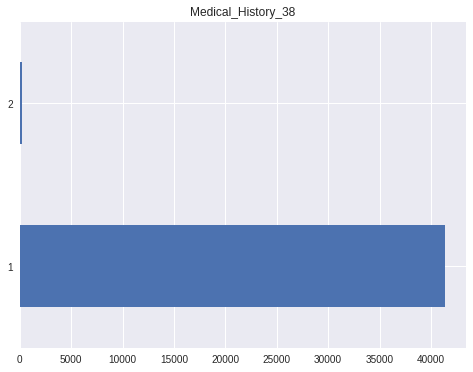

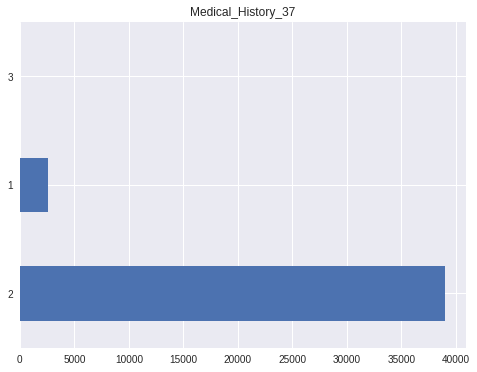

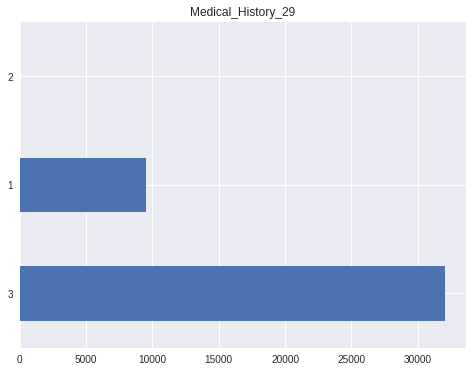

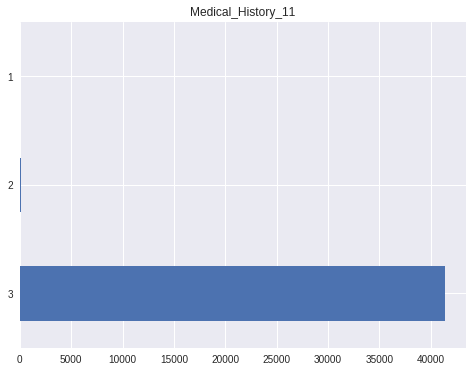

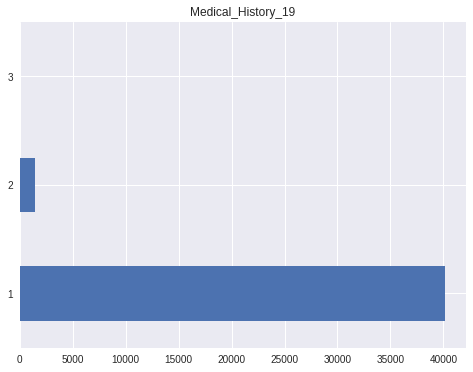

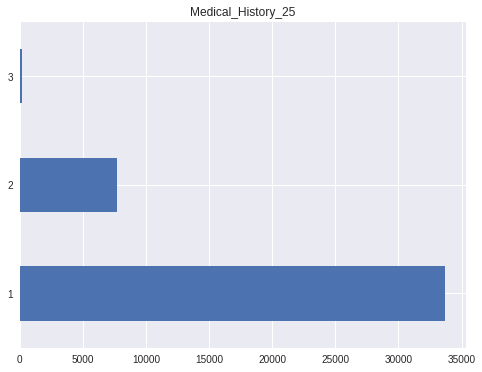

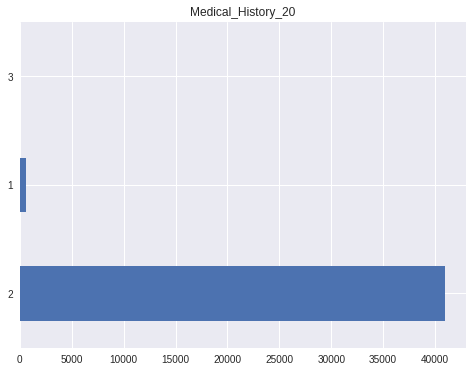

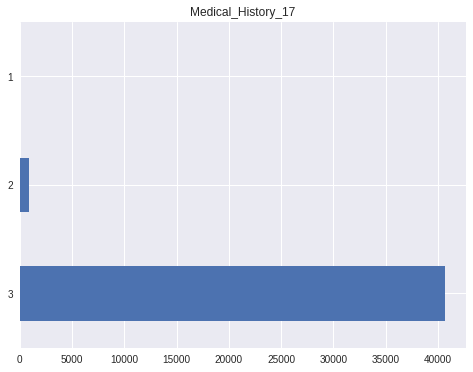

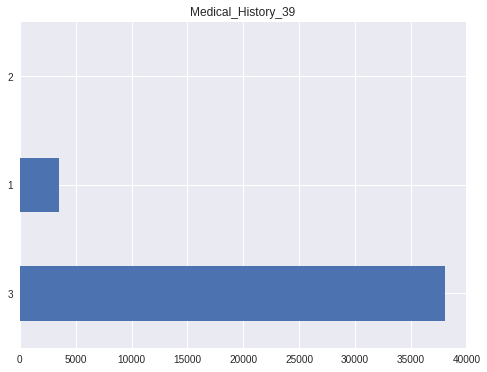

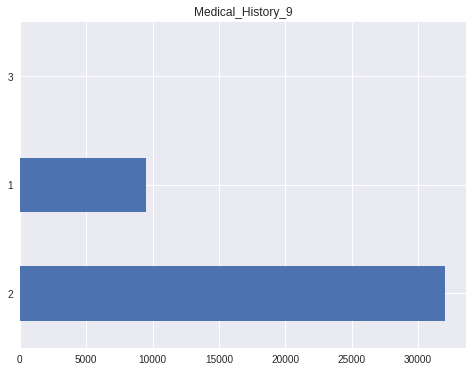

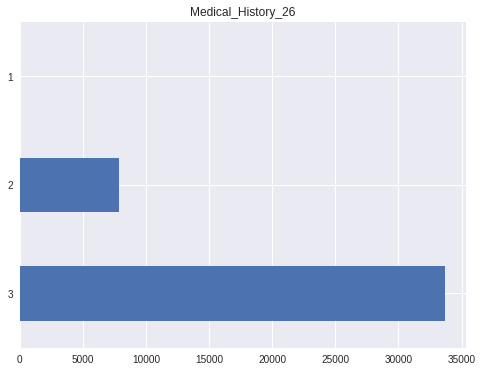

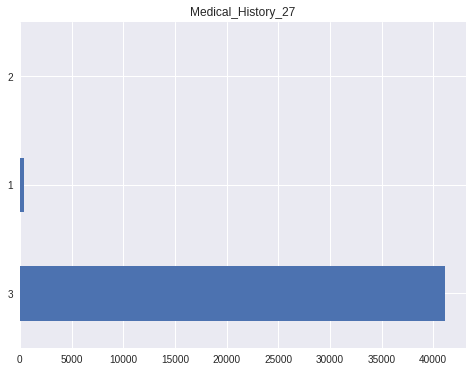

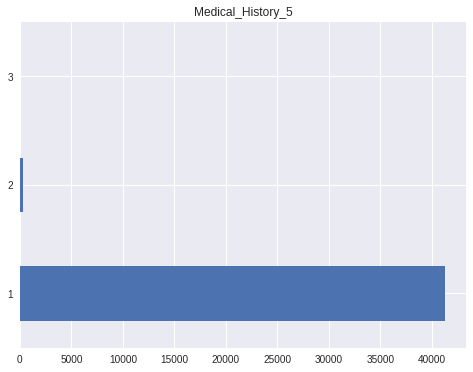

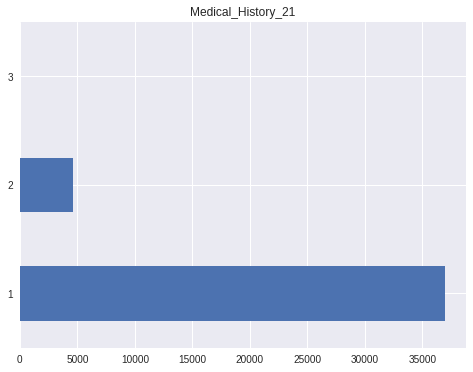

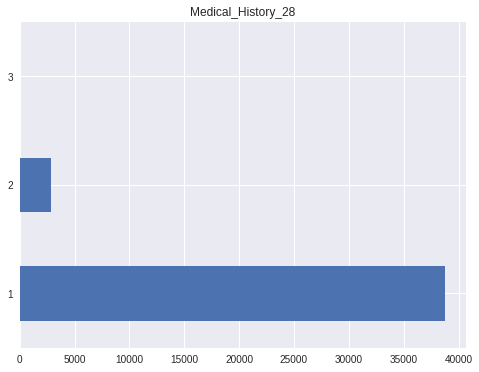

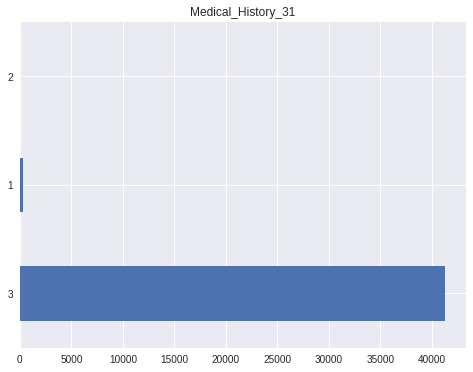

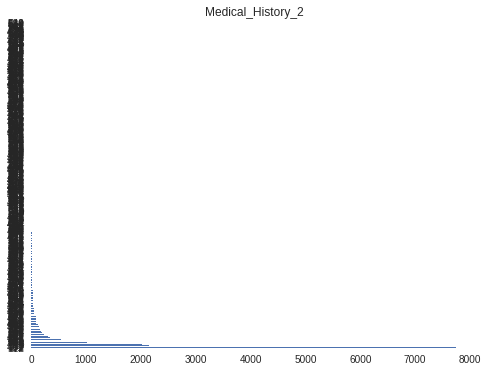

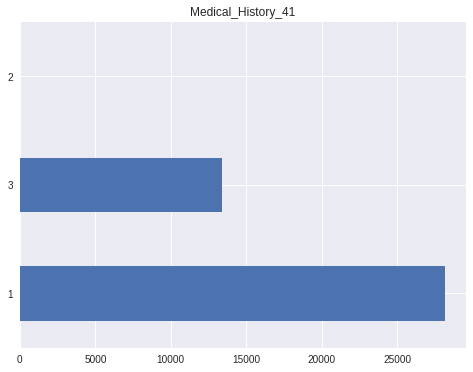

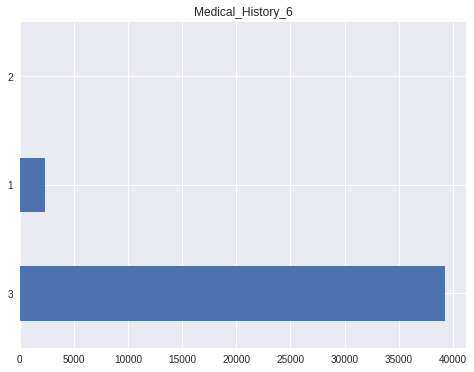

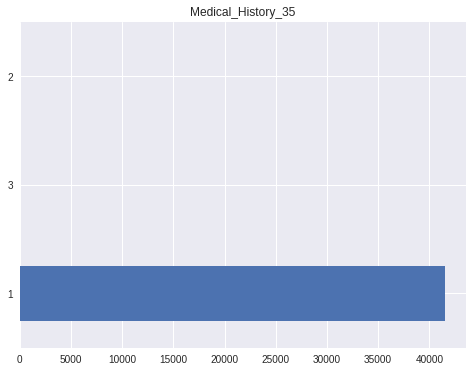

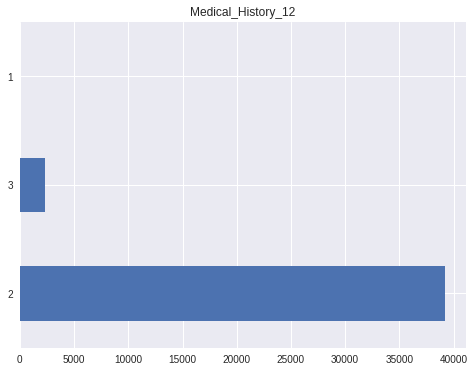

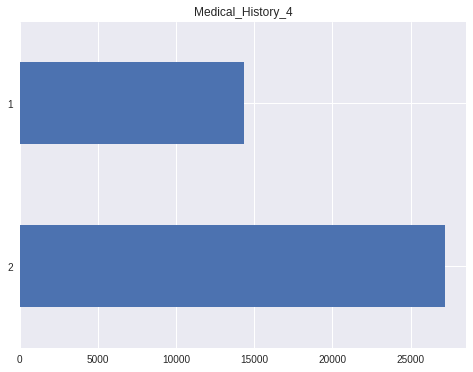

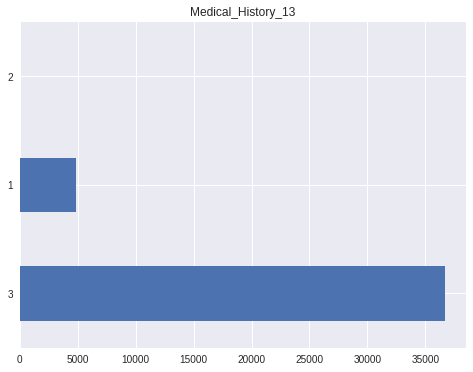

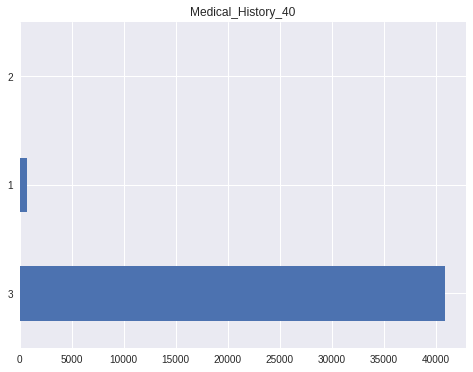

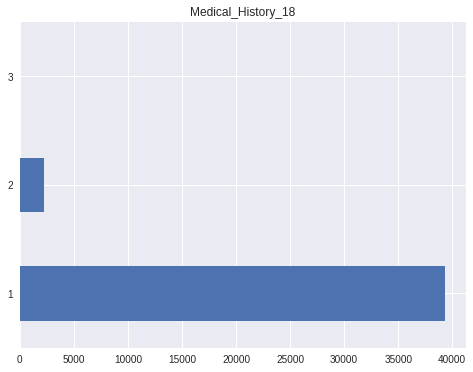

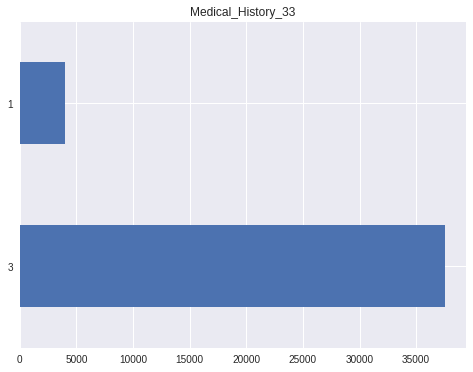

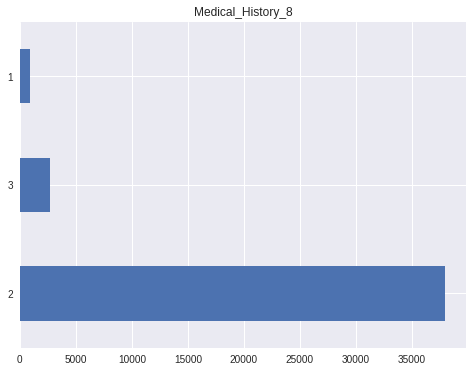

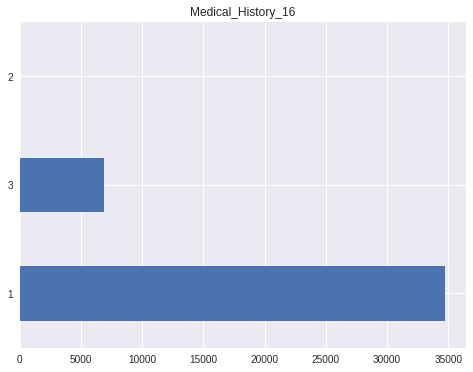

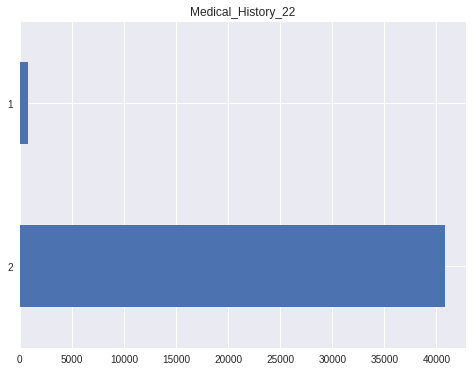

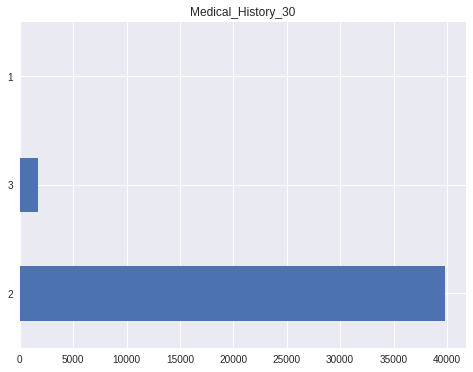

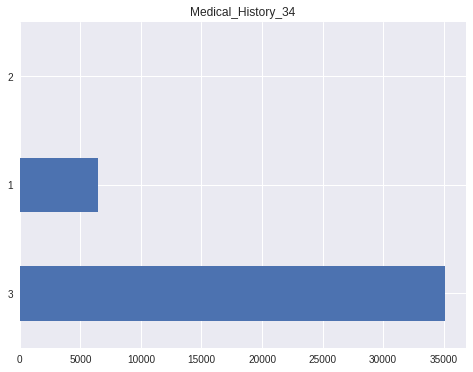

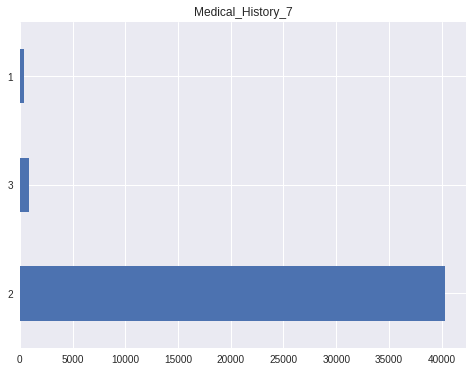

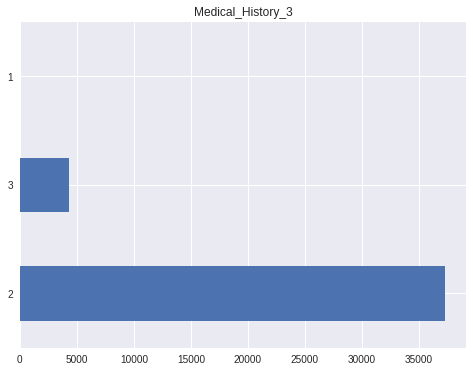

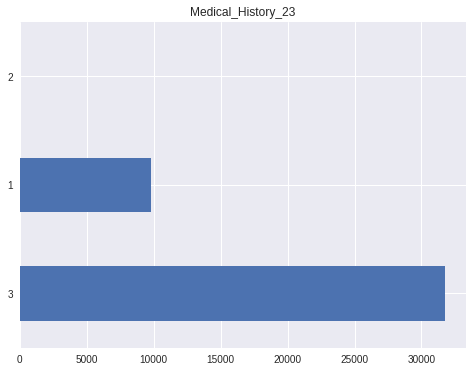

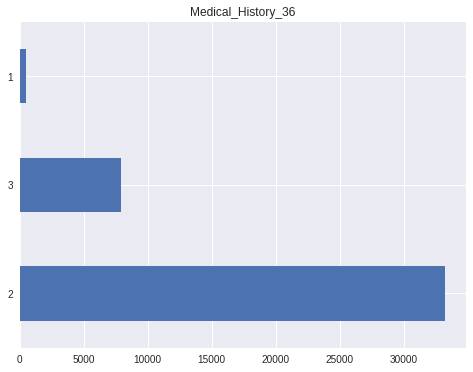

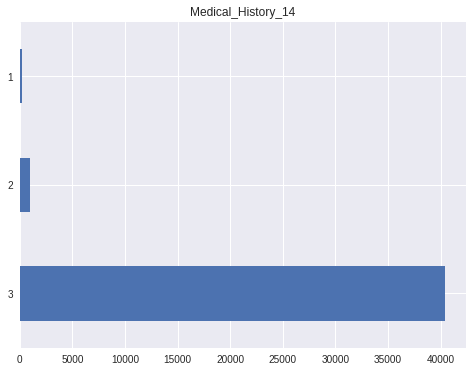

In [69]:
list_Medical_History_col_wo_nan = complement_col_func( Medical_History_df, list_col_nan)
print(list_Medical_History_col_wo_nan)
plot_barh_func( Medical_History_df[list_Medical_History_col_wo_nan], bar=True)

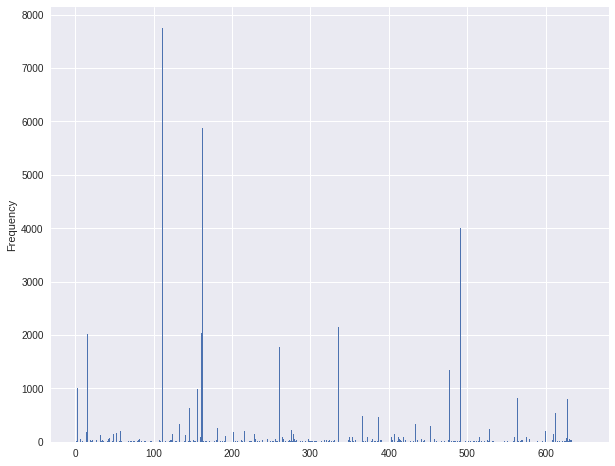

In [70]:
Medical_History_df.Medical_History_2.plot.hist( bins=500, figsize=(10, 8))

Removing, because the only not categorical column.

In [71]:
list_Medical_History_col_wo_nan.remove("Medical_History_2")

train_df[list_Medical_History_col_wo_nan] = train_df[list_Medical_History_col_wo_nan].astype('object')

"Medical_History_2" should be scaled.

In [72]:
train_df.Medical_History_2.head()

56199    565
42107    132
30424    160
38997    335
19945    161
Name: Medical_History_2, dtype: int64

In [73]:
sc = StandardScaler()
train_df.Medical_History_2 = sc.fit_transform(train_df.Medical_History_2)
test_df.Medical_History_2 = sc.transform(test_df.Medical_History_2)

/home/dmitryru/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dmitryru/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dmitryru/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1)

In [74]:
train_df.Medical_History_2.head()

56199    1.741580
42107   -0.684284
30424   -0.527415
38997    0.453015
19945   -0.521812
Name: Medical_History_2, dtype: float64

## Ins_Age, Ht, Wt, BMI. Removing outliers.

In [75]:
parameters_col_list = ["Ins_Age", "Ht", "Wt", "BMI"]
IHWB_df = train_df[parameters_col_list]
#IHWB_and_target_df = train_df[["Ins_Age", "Ht", "Wt", "BMI", "Response"]]

In [76]:
IHWB_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41566 entries, 56199 to 38060
Data columns (total 4 columns):
Ins_Age    41566 non-null float64
Ht         41566 non-null float64
Wt         41566 non-null float64
BMI        41566 non-null float64
dtypes: float64(4)
memory usage: 1.6 MB


In [77]:
IHWB_df.describe()

Ins_Age            Ht            Wt           BMI
count  41566.000000  41566.000000  41566.000000  41566.000000
mean       0.406123      0.707202      0.292511      0.469431
std        0.197701      0.074173      0.089176      0.122740
min        0.000000      0.000000      0.064854      0.058838
25%        0.238806      0.654545      0.225941      0.384723
50%        0.402985      0.709091      0.288703      0.451259
75%        0.567164      0.763636      0.345188      0.532858
max        0.925373      1.000000      1.000000      1.000000

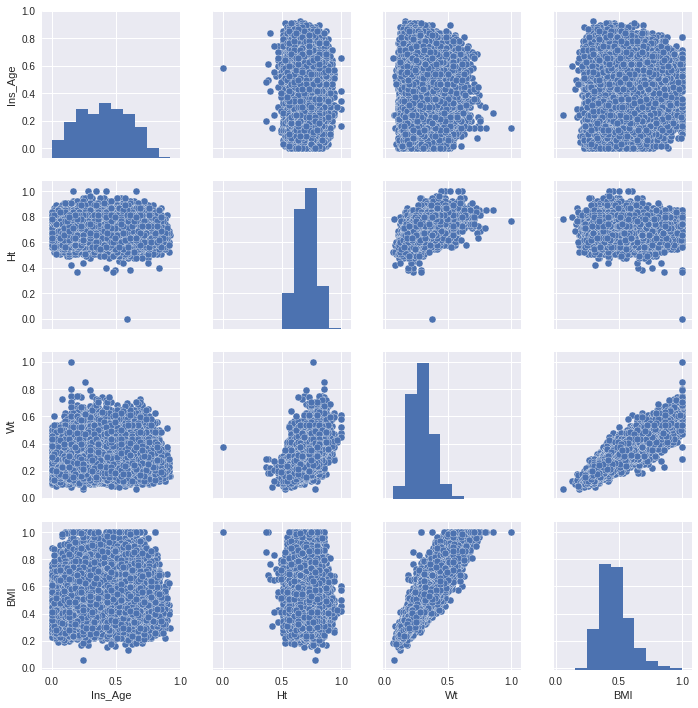

In [78]:
sns_plot = sns.pairplot(IHWB_df)

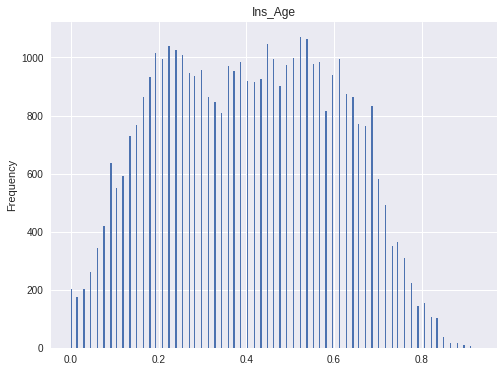

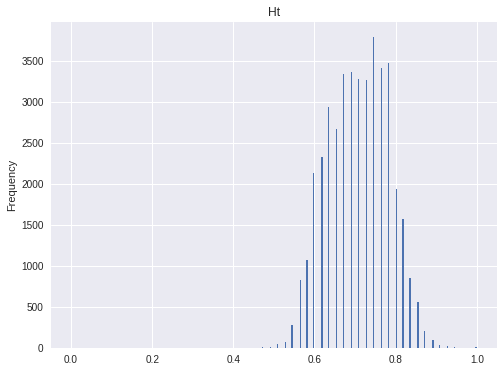

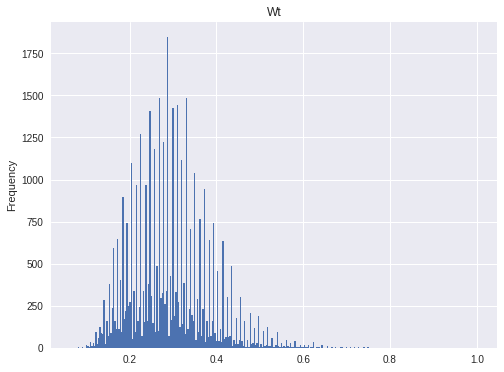

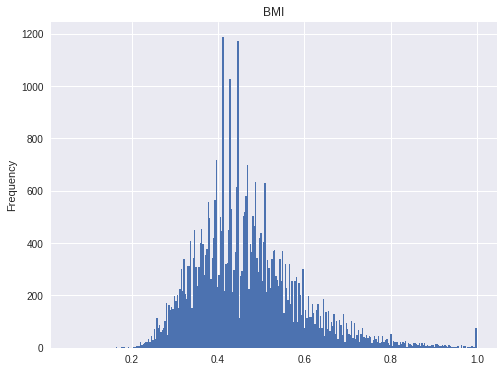

In [79]:
plot_barh_func(IHWB_df, bar=False)

In [80]:
IHWB_df[IHWB_df["Ht"] == 0]

Ins_Age   Ht        Wt  BMI
36117  0.58209  0.0  0.372385  1.0

In [81]:
IHWB_df[IHWB_df["Wt"] == 1]

Ins_Age        Ht   Wt  BMI
12935  0.149254  0.763636  1.0  1.0

Removing the outliers.

In [82]:
train_df_temp = pd.concat([train_df, y_train], axis=1)

In [83]:
train_df_temp = train_df_temp[(train_df_temp["Wt"] < 1.0) & ( train_df_temp["Ht"] > 0)]
print(train_df_temp.shape)
y_train = train_df_temp.pop("Response")
train_df = train_df_temp
print(train_df.shape, y_train.shape)

(41564, 127)
(41564, 126) (41564,)


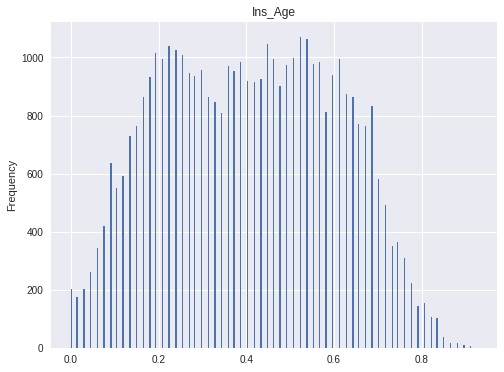

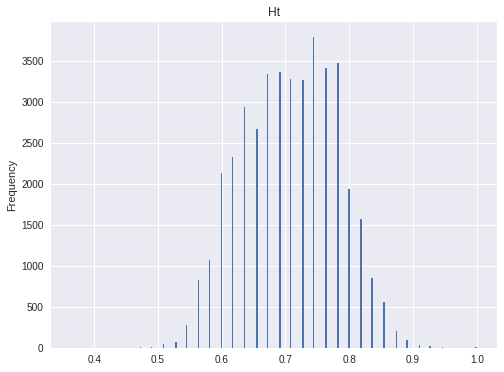

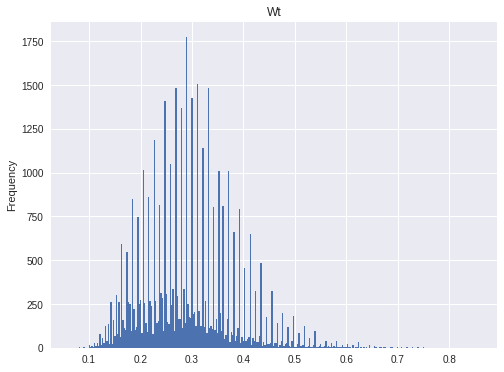

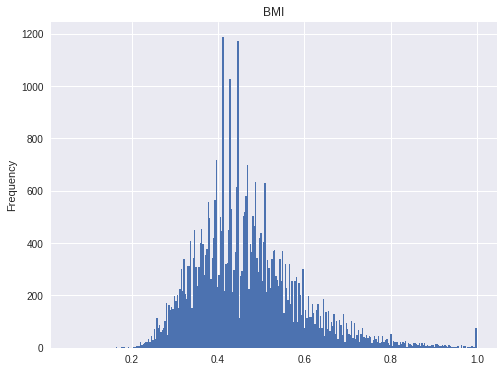

In [84]:
plot_barh_func(train_df[parameters_col_list], bar=False)

# Modeling.

## First model without replacing the NaNs.

### Preprocessing.

One-Hot-encoding of categorical features.

In [85]:
list_col_wo_nan = complement_col_func(train_df, list_col_nan)
#list_col_wo_nan

In [86]:
train_df.shape

(41564, 126)

In [87]:
pipeline = make_pipeline(category_encoders.OneHotEncoder(handle_unknown="ignore"))

X_train_01 = pipeline.fit_transform(train_df[list_col_wo_nan])
X_test_01 = pipeline.transform(test_df[list_col_wo_nan])

print( X_train_01.shape, X_test_01.shape)

(41564, 293) (17815, 293)


Scaling.

In [88]:
# sc = StandardScaler()
# X_train_01_scaled = sc.fit_transform(X_train_01.values)
# X_test_01_scaled = sc.transform(X_test_01.values)

# X_train_01_scaled_csr = sparse.csr_matrix(X_train_01_scaled)
# X_test_01_scaled_csr = sparse.csr_matrix(X_test_01_scaled)

### Logistic Regression.

Finding best regularization parameters using GridSearch.

In [89]:
my_scorer = make_scorer(f1_score, average='macro')
skv = StratifiedKFold(5)

In [86]:
%%time

tuned_parameters = [{'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}]

clf = GridSearchCV(LogisticRegression(random_state=17,
                                      class_weight='balanced'),
                   tuned_parameters,
                   scoring=my_scorer,
                   cv=skv, verbose=2, n_jobs=-1)

clf.fit(X_train_01.values, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=  14.6s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=  14.7s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=  14.9s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=  15.6s
[CV] C=0.05 .....

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  3.5min


[CV] .............................................. C=5, total= 1.4min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 1.5min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 1.5min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 1.5min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 1.5min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 1.7min
[CV] ............................................. C=50, total= 2.0min
[CV] ............................................. C=50, total= 2.3min
[CV] ............................................. C=50, total= 2.0min
[CV] .

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.7min finished


CPU times: user 1min 25s, sys: 711 ms, total: 1min 26s
Wall time: 8min


In [87]:
clf.best_estimator_

LogisticRegression(C=50, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [88]:
y_true, y_pred = y_test, clf.predict(X_test_01.values)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          1       0.35      0.29      0.31      1862
          2       0.33      0.24      0.28      1966
          3       0.11      0.40      0.17       304
          4       0.16      0.56      0.25       428
          5       0.38      0.41      0.39      1630
          6       0.41      0.22      0.29      3370
          7       0.41      0.32      0.36      2408
          8       0.67      0.78      0.72      5847

avg / total       0.47      0.45      0.45     17815



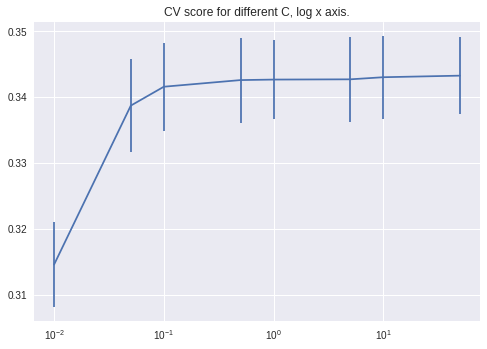

In [89]:
clf_results = pd.DataFrame.from_dict(clf.cv_results_)

fig = plt.figure()
ax = fig.add_subplot(111) 
ax.set_xscale("log", nonposx='clip')
plt.errorbar(clf_results['param_C'],
             clf_results['mean_test_score'],
             yerr=clf_results['std_test_score'])
plt.title("CV score for different C, log x axis.")

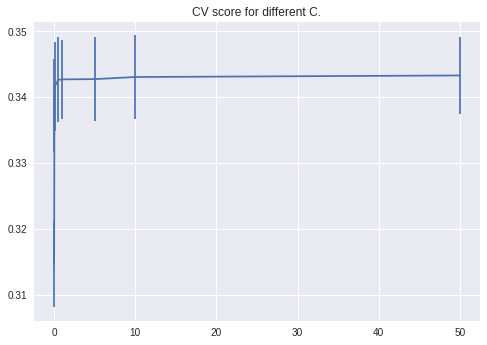

In [90]:
clf_results = pd.DataFrame.from_dict(clf.cv_results_)
plt.errorbar(clf_results['param_C'],
             clf_results['mean_test_score'],
             yerr=clf_results['std_test_score'])
plt.title("CV score for different C.")

In [174]:
class_names =range(1, 9)

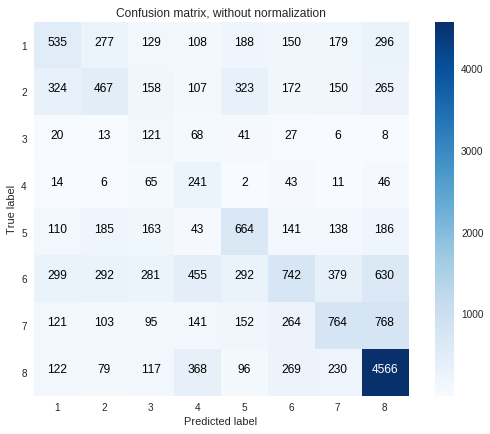

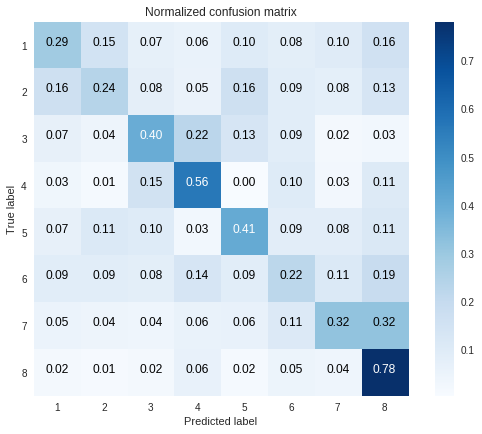

In [91]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig("ConMatrix.png")

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
plt.savefig("ConMatrixNorm.png")

### KNN Classifier

KNN wouldn't work with such amount of data. Therefor we use dimensionality reduction. We want to preserve 90% of variance.

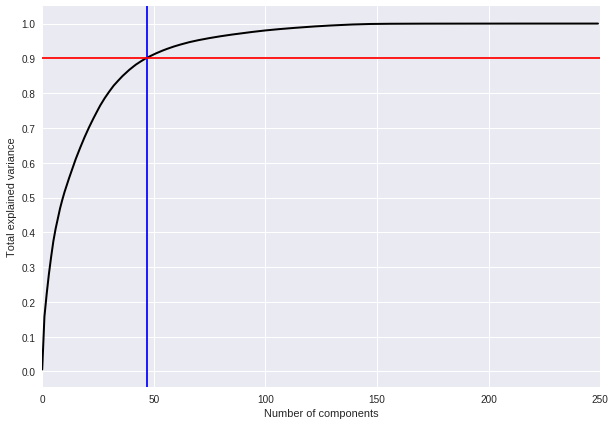

In [212]:
tSVD = TruncatedSVD( n_components=250,
                    random_state=17).fit(X_train_01.values)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(tSVD.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 250)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(47, c='b')
plt.axhline(0.9, c='r')
plt.show()

In [120]:
tSVD = TruncatedSVD(n_components=47, random_state=17)
X_train_01_reduced = tSVD.fit_transform(X_train_01.values)
X_test_01_reduced = tSVD.transform(X_test_01.values)

In [121]:
%%time

tuned_parameters = [{'n_neighbors': [ 3, 5, 7], 
                     'weights': ['uniform', 'distance']}]

clf = GridSearchCV( KNeighborsClassifier(), tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2, n_jobs=-1)
clf.fit( X_train_01_reduced, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=distance .................................
[CV] ................... n_neighbors=3, weights=uniform, total=  47.1s
[CV] n_neighbors=3, weights=distance .................................
[CV] .................. n_neighbors=3, weights=distance, total=  47.4s
[CV] n_neighbors=3, weights=distance .................................
[CV] ................... n_neighbors=3, weights=uniform, total=  47.0s
[CV] n_neighbors=3, weights=distance .................................
[CV] ................... n_neighbors=3, weights=uniform, total=  46.7s
[CV] n_neighbors=

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.8min finished


CPU times: user 2.36 s, sys: 309 ms, total: 2.67 s
Wall time: 15min 47s


In [122]:
%%time
print(clf.best_estimator_)

y_true, y_pred = y_test, clf.predict(X_test_01_reduced)
print(classification_report(y_true, y_pred))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')
             precision    recall  f1-score   support

          1       0.26      0.19      0.22      1862
          2       0.21      0.14      0.17      1966
          3       0.11      0.05      0.07       304
          4       0.09      0.05      0.06       428
          5       0.12      0.08      0.10      1630
          6       0.30      0.31      0.30      3370
          7       0.24      0.16      0.19      2408
          8       0.50      0.74      0.60      5847

avg / total       0.32      0.37      0.33     17815

CPU times: user 1min, sys: 0 ns, total: 1min
Wall time: 1min


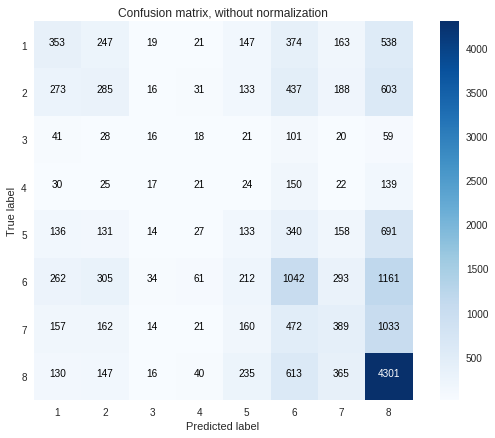

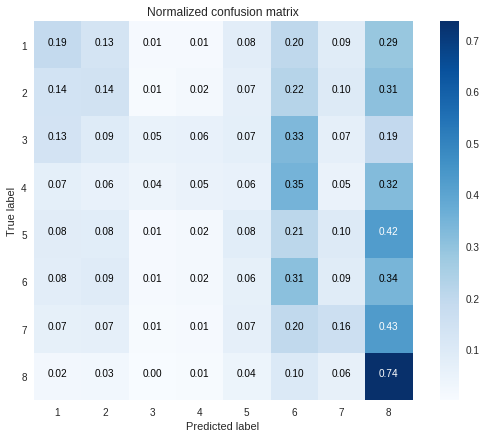

In [123]:
class_names =range(1, 9)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig("ConMatrix.png")

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
plt.savefig("ConMatrixNorm.png")

## Working with NaN.

### Fillna and use StandardScaler.

In [90]:
list_col_nan

['Medical_History_10',
 'Medical_History_32',
 'Medical_History_24',
 'Medical_History_15',
 'Family_Hist_5',
 'Family_Hist_3',
 'Family_Hist_2',
 'Insurance_History_5',
 'Family_Hist_4',
 'Employment_Info_6',
 'Medical_History_1',
 'Employment_Info_4',
 'Employment_Info_1']

In [91]:
train_df_NaN = train_df[list_col_nan]
test_df_NaN = test_df[list_col_nan]

In [92]:
train_df_NaN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41564 entries, 56199 to 38060
Data columns (total 13 columns):
Medical_History_10     389 non-null float64
Medical_History_32     780 non-null float64
Medical_History_24     2650 non-null float64
Medical_History_15     10374 non-null float64
Family_Hist_5          12305 non-null float64
Family_Hist_3          17539 non-null float64
Family_Hist_2          21485 non-null float64
Insurance_History_5    23909 non-null float64
Family_Hist_4          28108 non-null float64
Employment_Info_6      33859 non-null float64
Medical_History_1      35314 non-null float64
Employment_Info_4      36875 non-null float64
Employment_Info_1      41549 non-null float64
dtypes: float64(13)
memory usage: 4.4 MB


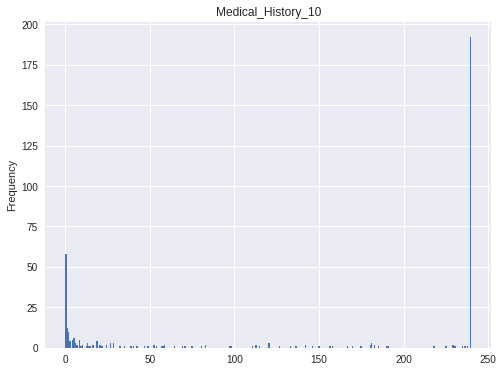

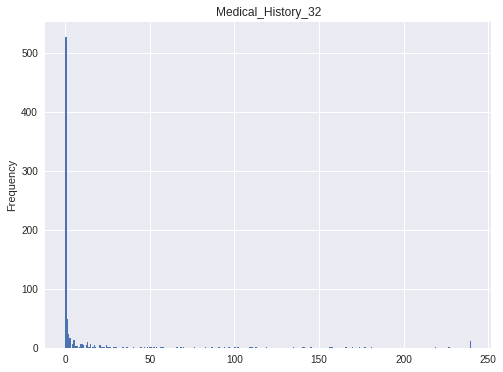

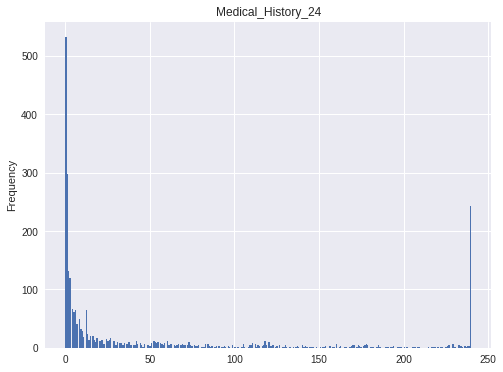

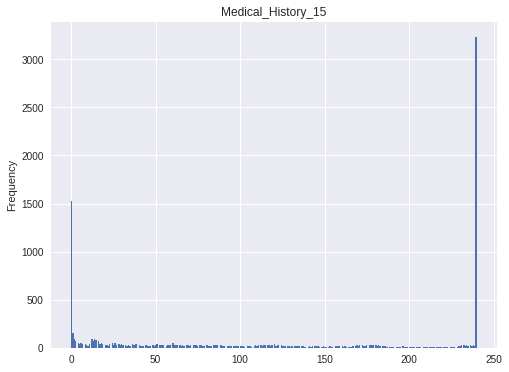

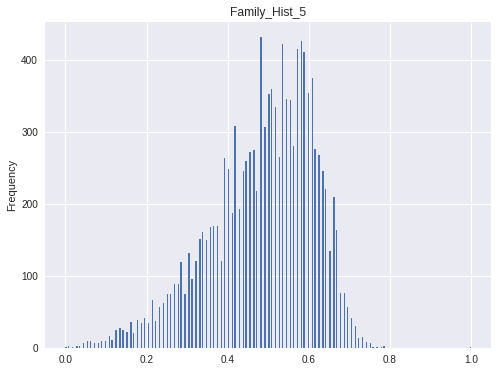

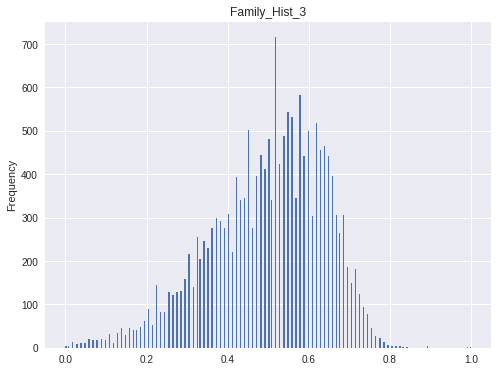

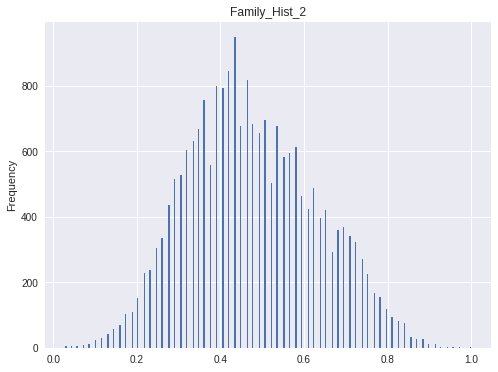

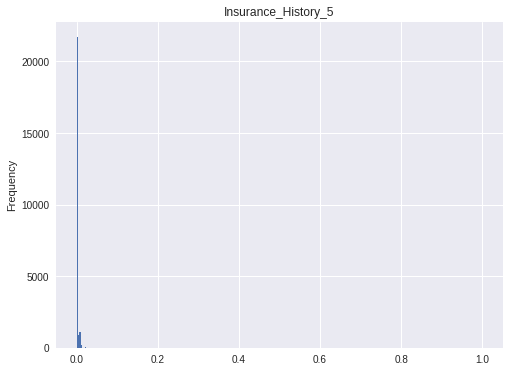

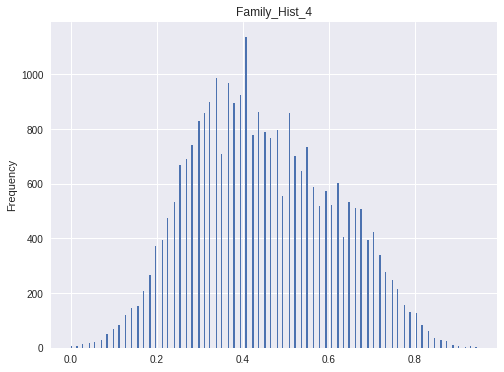

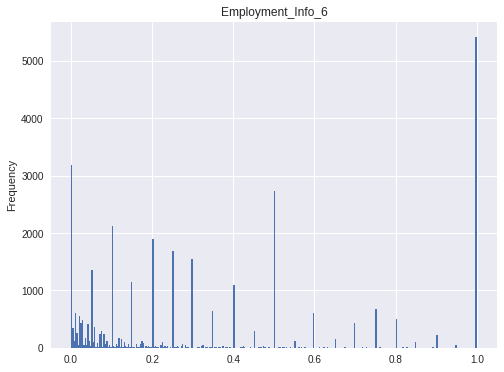

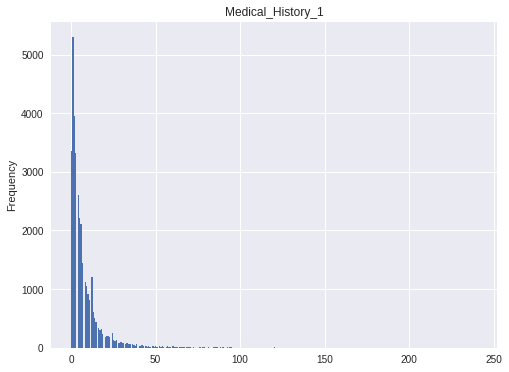

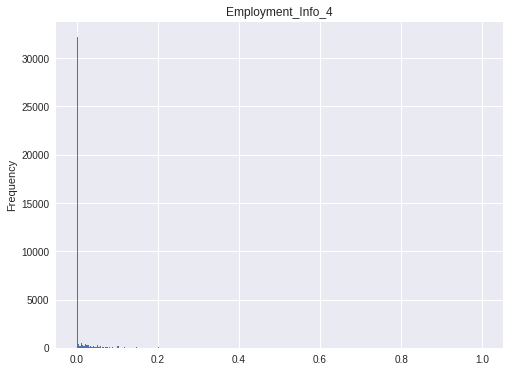

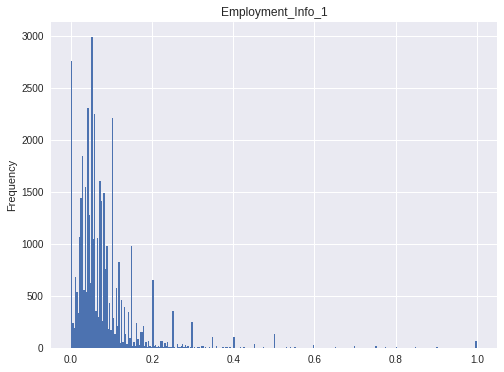

In [93]:
plot_barh_func(train_df_NaN, bar=False)

In [94]:
train_df_NaN.describe().T

count        mean         std       min        25%  \
Medical_History_10     389.0  141.359897  108.887386  0.000000   6.000000   
Medical_History_32     780.0   12.835897   40.592578  0.000000   0.000000   
Medical_History_24    2650.0   50.775094   78.927293  0.000000   1.000000   
Medical_History_15   10374.0  124.471853   98.605237  0.000000  18.000000   
Family_Hist_5        12305.0    0.485301    0.128156  0.000000   0.401786   
Family_Hist_3        17539.0    0.497781    0.141122  0.000000   0.401961   
Family_Hist_2        21485.0    0.475021    0.155269  0.028986   0.362319   
Insurance_History_5  23909.0    0.001737    0.007582  0.000000   0.000400   
Family_Hist_4        28108.0    0.445228    0.163747  0.000000   0.323944   
Employment_Info_6    33859.0    0.363393    0.350379  0.000000   0.060000   
Medical_History_1    35314.0    7.967435   12.874900  0.000000   2.000000   
Employment_Info_4    36875.0    0.006427    0.034496  0.000000   0.000000   
Employment_Info_1    41549.0    0.077703    0.082815  0.000000   0.035000   

                            50%         75%         max  
Medical_History_10   235.000000  240.000000  240.000000  
Medical_History_32     0.000000    2.000000  240.000000  
Medical_History_24     8.000000   62.000000  240.000000  
Medical_History_15   118.000000  240.000000  240.000000  
Family_Hist_5          0.508929    0.580357    1.000000  
Family_Hist_3          0.519608    0.607843    1.000000  
Family_Hist_2          0.463768    0.579710    1.000000  
Insurance_History_5    0.001000    0.002000    1.000000  
Family_Hist_4          0.422535    0.563380    0.943662  
Employment_Info_6      0.250000    0.550000    1.000000  
Medical_History_1      4.000000   10.000000  240.000000  
Employment_Info_4      0.000000    0.000000    1.000000  
Employment_Info_1      0.060000    0.100000    1.000000

In [95]:
train_df_NaN.Medical_History_32.fillna(0, inplace=True)

train_df_NaN.Employment_Info_4.fillna(0, inplace=True)

test_df_NaN.Medical_History_32.fillna(0, inplace=True)

test_df_NaN.Employment_Info_4.fillna(0, inplace=True)

In [96]:
list_fillna_median = ["Medical_History_1",
                      "Insurance_History_5",
                      "Employment_Info_1",
                      "Family_Hist_4"]

imp = Imputer(missing_values='NaN',
              strategy='median',
              axis=0,
              copy=False)

train_df_NaN[list_fillna_median] = imp.fit_transform(train_df_NaN[list_fillna_median])
test_df_NaN[list_fillna_median] = imp.transform(test_df_NaN[list_fillna_median])

In [97]:
train_df_NaN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41564 entries, 56199 to 38060
Data columns (total 13 columns):
Medical_History_10     389 non-null float64
Medical_History_32     41564 non-null float64
Medical_History_24     2650 non-null float64
Medical_History_15     10374 non-null float64
Family_Hist_5          12305 non-null float64
Family_Hist_3          17539 non-null float64
Family_Hist_2          21485 non-null float64
Insurance_History_5    41564 non-null float64
Family_Hist_4          41564 non-null float64
Employment_Info_6      33859 non-null float64
Medical_History_1      41564 non-null float64
Employment_Info_4      41564 non-null float64
Employment_Info_1      41564 non-null float64
dtypes: float64(13)
memory usage: 4.4 MB


In [98]:
col_wo_NAN = list(train_df_NaN.columns[~train_df_NaN.isnull().any()])
col_wo_NAN

['Medical_History_32',
 'Insurance_History_5',
 'Family_Hist_4',
 'Medical_History_1',
 'Employment_Info_4',
 'Employment_Info_1']

In [99]:
train_df_NaN[col_wo_NAN].describe().T

count      mean        std  min       25%       50%  \
Medical_History_32   41564.0  0.240882   5.823855  0.0  0.000000  0.000000   
Insurance_History_5  41564.0  0.001424   0.005762  0.0  0.000667  0.001000   
Family_Hist_4        41564.0  0.437882   0.135075  0.0  0.380282  0.422535   
Medical_History_1    41564.0  7.370850  11.951888  0.0  2.000000  4.000000   
Employment_Info_4    41564.0  0.005702   0.032555  0.0  0.000000  0.000000   
Employment_Info_1    41564.0  0.077696   0.082801  0.0  0.035000  0.060000   

                          75%         max  
Medical_History_32   0.000000  240.000000  
Insurance_History_5  0.001333    1.000000  
Family_Hist_4        0.492958    0.943662  
Medical_History_1    8.000000  240.000000  
Employment_Info_4    0.000000    1.000000  
Employment_Info_1    0.099970    1.000000

In [100]:
scaler_data_NaN = StandardScaler()

train_df_NaN[[ "Medical_History_32",
              "Medical_History_1"]] = scaler_data_NaN.fit_transform(train_df_NaN[[ "Medical_History_32",
                                                                                  "Medical_History_1"]].values)
test_df_NaN[[ "Medical_History_32",
              "Medical_History_1"]] = scaler_data_NaN.transform(test_df_NaN[[ "Medical_History_32",
                                                                                  "Medical_History_1"]].values)

In [101]:
train_df_NaN[col_wo_NAN].describe().T

count          mean       std       min       25%  \
Medical_History_32   41564.0  1.954541e-15  1.000012 -0.041362 -0.041362   
Insurance_History_5  41564.0  1.423840e-03  0.005762  0.000000  0.000667   
Family_Hist_4        41564.0  4.378816e-01  0.135075  0.000000  0.380282   
Medical_History_1    41564.0  6.421899e-17  1.000012 -0.616718 -0.449378   
Employment_Info_4    41564.0  5.702045e-03  0.032555  0.000000  0.000000   
Employment_Info_1    41564.0  7.769644e-02  0.082801  0.000000  0.035000   

                          50%       75%        max  
Medical_History_32  -0.041362 -0.041362  41.168950  
Insurance_History_5  0.001000  0.001333   1.000000  
Family_Hist_4        0.422535  0.492958   0.943662  
Medical_History_1   -0.282038  0.052641  19.464034  
Employment_Info_4    0.000000  0.000000   1.000000  
Employment_Info_1    0.060000  0.099970   1.000000

In [102]:
X_train_02 = pd.concat([X_train_01, train_df_NaN[col_wo_NAN]], axis=1)
X_test_02 = pd.concat([X_test_01, test_df_NaN[col_wo_NAN]], axis=1)

### Logistic Regression.

In [105]:
%%time

tuned_parameters = [{'C':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}]

clf = GridSearchCV(LogisticRegression(random_state=17,
                                      class_weight='balanced'),
                   tuned_parameters,
                   scoring=my_scorer,
                   cv=skv, verbose=2, n_jobs=-1)
clf.fit(X_train_02.values, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=  14.6s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=  14.3s
[CV] ........................................... C=0.01, total=  14.6s
[CV] C=0.05 ..........................................................
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=  15.0s
[CV] C=0.05 .....

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  4.0min


[CV] .............................................. C=5, total= 1.6min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 1.8min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 1.9min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 2.0min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 1.8min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 2.0min
[CV] ............................................. C=50, total= 2.6min
[CV] ............................................. C=50, total= 2.3min
[CV] ............................................. C=50, total= 2.1min
[CV] .

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.7min finished


CPU times: user 32.3 s, sys: 608 ms, total: 32.9 s
Wall time: 8min 4s


In [106]:
y_true, y_pred = y_test, clf.predict(X_test_02.values)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          1       0.36      0.30      0.33      1862
          2       0.34      0.24      0.28      1966
          3       0.11      0.40      0.17       304
          4       0.16      0.57      0.24       428
          5       0.38      0.40      0.39      1630
          6       0.41      0.22      0.28      3370
          7       0.42      0.31      0.36      2408
          8       0.67      0.79      0.72      5847

avg / total       0.47      0.46      0.45     17815



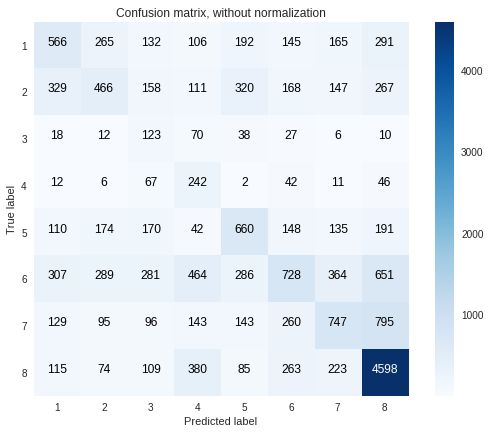

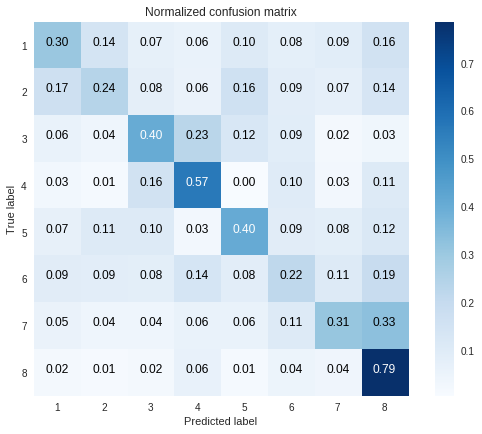

In [107]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig("ConMatrix.png")

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
plt.savefig("ConMatrixNorm.png")

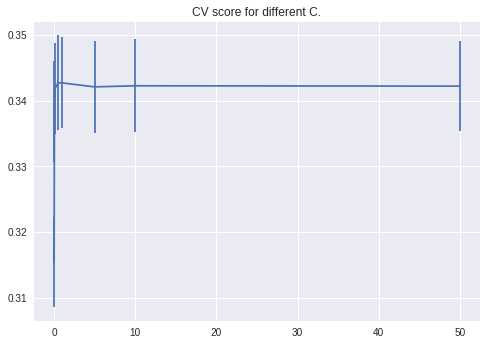

In [108]:
clf_results = pd.DataFrame.from_dict(clf.cv_results_)
plt.errorbar(clf_results['param_C'], clf_results['mean_test_score'], yerr=clf_results['std_test_score'])
plt.title("CV score for different C.")

In [109]:
clf.best_estimator_

LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# Feature Generation.

In [160]:
X_train_03 = X_train_02.copy()
X_test_03 = X_test_02.copy()
print(X_train_02.shape, X_test_02.shape)

(41564, 299) (17815, 299)


In [161]:
X_train_03.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41564 entries, 56199 to 38060
Columns: 299 entries, Product_Info_5_0 to Employment_Info_1
dtypes: float64(12), int64(287)
memory usage: 95.1 MB


In [162]:
numreic_cols = list(X_train_03.select_dtypes(include=['float64']))
numreic_cols

['BMI',
 'Wt',
 'Product_Info_4',
 'Ins_Age',
 'Ht',
 'Medical_History_2',
 'Medical_History_32',
 'Insurance_History_5',
 'Family_Hist_4',
 'Medical_History_1',
 'Employment_Info_4',
 'Employment_Info_1']

In [163]:
X_train_03[numreic_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41564 entries, 56199 to 38060
Data columns (total 12 columns):
BMI                    41564 non-null float64
Wt                     41564 non-null float64
Product_Info_4         41564 non-null float64
Ins_Age                41564 non-null float64
Ht                     41564 non-null float64
Medical_History_2      41564 non-null float64
Medical_History_32     41564 non-null float64
Insurance_History_5    41564 non-null float64
Family_Hist_4          41564 non-null float64
Medical_History_1      41564 non-null float64
Employment_Info_4      41564 non-null float64
Employment_Info_1      41564 non-null float64
dtypes: float64(12)
memory usage: 4.1 MB


In [164]:
X_train_03[numreic_cols].describe().T

count          mean       std       min       25%  \
BMI                  41564.0  4.694056e-01  0.122688  0.058838  0.384718   
Wt                   41564.0  2.924924e-01  0.089110  0.064854  0.225941   
Product_Info_4       41564.0  3.293059e-01  0.281976  0.000000  0.076923   
Ins_Age              41564.0  4.061253e-01  0.197700  0.000000  0.238806   
Ht                   41564.0  7.072173e-01  0.074093  0.363636  0.654545   
Medical_History_2    41564.0  1.924796e-06  0.999991 -1.418205 -0.796333   
Medical_History_32   41564.0  1.954541e-15  1.000012 -0.041362 -0.041362   
Insurance_History_5  41564.0  1.423840e-03  0.005762  0.000000  0.000667   
Family_Hist_4        41564.0  4.378816e-01  0.135075  0.000000  0.380282   
Medical_History_1    41564.0  6.421899e-17  1.000012 -0.616718 -0.449378   
Employment_Info_4    41564.0  5.702045e-03  0.032555  0.000000  0.000000   
Employment_Info_1    41564.0  7.769644e-02  0.082801  0.000000  0.035000   

                          50%       75%        max  
BMI                  0.451259  0.532858   1.000000  
Wt                   0.288703  0.345188   0.853556  
Product_Info_4       0.230769  0.487179   1.000000  
Ins_Age              0.402985  0.567164   0.925373  
Ht                   0.709091  0.763636   1.000000  
Medical_History_2   -0.516210  0.906814   2.206584  
Medical_History_32  -0.041362 -0.041362  41.168950  
Insurance_History_5  0.001000  0.001333   1.000000  
Family_Hist_4        0.422535  0.492958   0.943662  
Medical_History_1   -0.282038  0.052641  19.464034  
Employment_Info_4    0.000000  0.000000   1.000000  
Employment_Info_1    0.060000  0.099970   1.000000

In [165]:
def brute_feat_gen(df, num_col_names):
    for name1 in tqdm_notebook(num_col_names):
        for name2 in num_col_names:
            df[name1 + "_X_" + name2] =  df[name1] * df[name2]
            df[name1 + "_powers3" ] =  df[name1] * df[name1] * df[name1]
            if name1 in [ "Medical_History_2",
                         "Medical_History_32",
                         "Medical_History_1"]:
                df["sqrt_" + name1] = np.cbrt(df[name1])
            else:
                df["sqrt_" + name1] =  np.sqrt(df[name1])
    print( df.shape)
    return df

In [166]:
X_train_03_fg = brute_feat_gen(X_train_03, numreic_cols)


(41564, 467)


In [167]:
X_test_03_fg = brute_feat_gen(X_test_03, numreic_cols)


(17815, 467)


In [173]:
%%time

tuned_parameters = [{'C':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}]

clf = GridSearchCV(LogisticRegression(random_state=17,
                                      class_weight='balanced'),
                   tuned_parameters,
                   scoring=my_scorer,
                   cv=skv, verbose=2, n_jobs=-1)
clf.fit(X_train_03_fg.values, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total= 3.2min
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total= 3.2min
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total= 3.3min
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total= 3.4min
[CV] C=0.05 .....

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 27.2min


[CV] .............................................. C=5, total= 7.2min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 5.4min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 7.1min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 6.8min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 6.5min
[CV] C=50 ............................................................
[CV] ............................................. C=10, total= 5.5min
[CV] ............................................. C=50, total= 5.7min
[CV] ............................................. C=50, total= 4.8min
[CV] ............................................. C=50, total= 4.0min
[CV] .

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 37.0min finished


CPU times: user 2min 35s, sys: 1.25 s, total: 2min 37s
Wall time: 39min 21s


In [175]:
print(clf.best_estimator_)

y_true, y_pred = y_test, clf.predict(X_test_03_fg.values)
print(classification_report(y_true, y_pred))

LogisticRegression(C=0.05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.37      0.31      0.34      1862
          2       0.35      0.22      0.27      1966
          3       0.12      0.44      0.18       304
          4       0.15      0.60      0.24       428
          5       0.42      0.34      0.38      1630
          6       0.40      0.22      0.28      3370
          7       0.40      0.31      0.35      2408
          8       0.64      0.78      0.70      5847

avg / total       0.46      0.45      0.44     17815



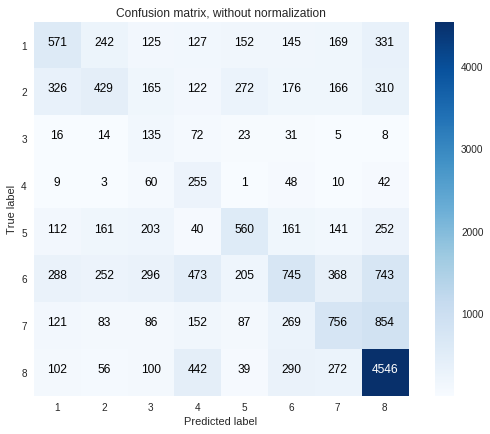

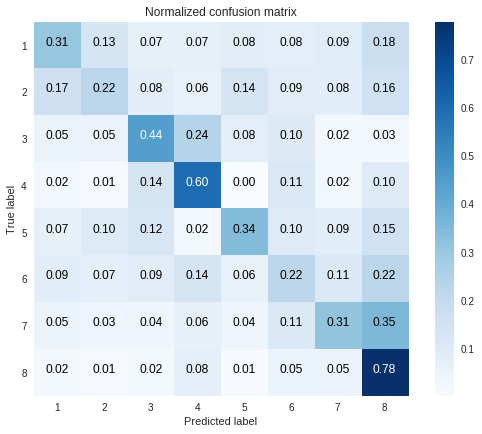

In [176]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig("ConMatrix.png")

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
plt.savefig("ConMatrixNorm.png")

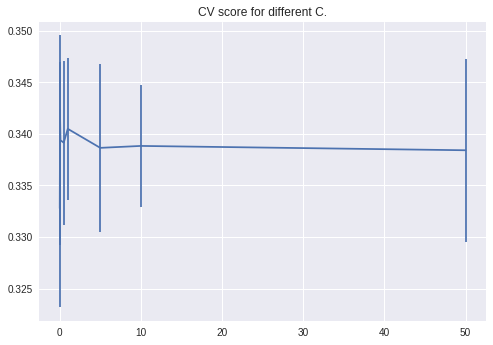

In [177]:
clf_results = pd.DataFrame.from_dict(clf.cv_results_)
plt.errorbar(clf_results['param_C'], clf_results['mean_test_score'], yerr=clf_results['std_test_score'])
plt.title("CV score for different C.")